# Setup

In [1]:
from ipdb import set_trace as bp
import torch
import mdtraj as md
import os
import numpy as np
from scipy.stats import shapiro
import warnings
from typing import Union
import ipynbname
import openmm
from openmm import LocalEnergyMinimizer
from openmm.unit import *
from contextlib import redirect_stdout
from tqdm import tqdm
from mdtraj.reporters import NetCDFReporter
import copy
from itertools import combinations
import nflows
import scipy
from scipy import stats
import math


#BGMOL
import bgmol
import bgflow as bg
from bgflow.utils.types import assert_numpy
from bgmol.systems.peptide import peptide
from bgmol.zmatrix import ZMatrixFactory
from bgflow.nn.flow.transformer.base import Flow
from bgflow import (BoltzmannGeneratorBuilder, BONDS, ANGLES, TORSIONS, FIXED, AUGMENTED, ORIGIN, ROTATION, ShapeDictionary)
from bgflow import InternalCoordinateMarginals, BoltzmannGeneratorBuilder
from bgmol import bond_constraints
from bgflow.distribution.energy.clipped import LinLogCutEnergy
from bgflow.utils import as_numpy

#Plotting and Visualisation
import nglview as nv
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import matplotlib as mpl
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA
import MDAnalysis.analysis.pca as pca
import MDAnalysis as mda
from MDAnalysis.analysis.dihedrals import Dihedral
from MDAnalysis.analysis import helix_analysis as hel
import ipywidgets as widgets


In [2]:
%load_ext autoreload

%autoreload 2

In [3]:
device = torch.device("cpu") if torch.cuda.is_available() else torch.device("cpu")
dtype = torch.float32

# a context tensor to send data to the right device and dtype via '.to(ctx)'
ctx = {"device": device, "dtype": dtype}

# a brief check if this module is the main executable (or imported)
main = (__name__ == "__main__")

# Define Peptide/load data

In [6]:
#first four lines have to adapted
complex_name = 'OppA'
peptide_name = '1b4z'
n_atoms = 59
n_res = 3

#filepath = f'/data/mcm/meyerml/BG/Systems/{complex_name}/Peptides/{peptide_name}'
filepath = f'/hits/basement/mcm/emmertme/Boltzmann/BG/Systems/{complex_name}/Peptides/{peptide_name}/10_7_steps'
system = peptide(short = False, n_atoms=n_atoms, n_res=n_res, filepath=filepath, complex_name=complex_name, peptide_name=peptide_name)
topology = system._mdtraj_topology

In [50]:
traj = md.load_pdb(os.path.join(filepath,'traj.pdb'), top=topology)

In [4]:
nb_fname = ipynbname.name()
nb_path = ipynbname.path()

#traj.save(f'traj{nb_fname}_7.h5')
traj=md.load_hdf5(f'traj{nb_fname}_7.h5')

traj.n_atoms
data = traj.xyz.reshape(len(traj.xyz), -1)

## Load explicit solvent traj

In [ ]:
filepath = f'/hits/basement/mcm/emmertme/Haswell_Peptide_Simulations/{complex_name}/Peptides/{peptide_name}/explicit_solvent/Output/Trajectory/'

expl_traj=md.load_hdf5(f'expl_traj{nb_fname}.h5')

In [32]:
widget = nv.show_mdtraj(expl_traj)
widget.add_representation("licorice")

widget

NGLWidget(max_frame=999)

In [ ]:
#list(expl_traj.topology.atoms)

# Visualize MD Data

In [7]:
def show_structures(traj, top=system.mdtraj_topology):
    if not isinstance(traj, md.Trajectory):
        n_samples = traj.shape[0]
        traj = md.Trajectory(traj.reshape(n_samples, -1, 3), topology=top)
    traj.superpose(traj)
    widget = nv.show_mdtraj(traj)
    widget.add_representation("licorice")
    return widget

wid=show_structures(data)
wid

NGLWidget(max_frame=9999)

## Split MD Data

In [52]:
#system.mdtraj_topology.to_dataframe()
xyz = traj.xyz #xyz are the trajectories coordinates
print('number of snapshots:', len(data))

n_train = len(data)//2
n_test = len(data) - n_train
permutation = np.random.permutation(n_train)

all_data = xyz.reshape(-1, traj.n_atoms*3)
training_data = torch.tensor(all_data[permutation], **ctx)
test_data = torch.tensor(all_data[permutation + n_train], **ctx)

print('dimensions training and test data:', training_data.shape, test_data.shape)

number of snapshots: 10000
dimensions training and test data: torch.Size([5000, 177]) torch.Size([5000, 177])


## PCA

In [53]:
# define target_energy, is later used in 'Build the BG'
system.reinitialize_energy_model(temperature=300, platform_name="CPU")
target_energy = system._energy_model 

/home/emmertme/bgflow/bgflow/distribution/energy/openmm.py:209: UserWarning: It looks like you are using an OpenMMBridge with multiple workers in an ipython environment. This can behave a bit silly upon KeyboardInterrupt (e.g., kill the stdout stream). If you experience any issues, consider initializing the bridge with n_workers=1 in ipython/jupyter.
  warnings.warn(


In [54]:
def distances(xyz):
    distance_matrix_ca = np.linalg.norm(xyz[:, None, :, :] - xyz[:, :, None, :], axis=-1)
    n_ca = distance_matrix_ca.shape[-1]
    m, n = np.triu_indices(n_ca, k=1)
    distances_ca = distance_matrix_ca[:, m, n]
    return distances_ca

def dihedrals(xyz):
    n_atoms = xyz.shape[1]
    top, traj = bgmol.build_fake_topology(n_atoms, coordinates=xyz)
    dihedral_indices = np.array( [list(range(i,i+4)) for i in range(n_atoms-3)] )
    dihedrals = md.compute_dihedrals(traj, dihedral_indices)
    return dihedrals

c_atoms = system.mdtraj_topology.select("backbone and (name C or name N)")#[:3]

system.reinitialize_energy_model(temperature=300, platform_name="CPU", n_workers = 1)
system.mdtraj_topology

def plot_pcs(ax, pcs, bins=100):
    #ax.set_xlim(-1, 1.5)
    #ax.set_ylim(-1.5, 2)
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.hist2d(pcs[...,0], pcs[...,1], bins=bins, #range=[[-.5,1.5], [-1.5,1]],
              density=True, norm=mpl.colors.LogNorm())

In [ ]:
pca2 = PCA(n_components=2)

atom_pairs = list(combinations(range(traj.n_atoms), 2))
pairwise_distances = md.geometry.compute_distances(traj, atom_pairs)
print(pairwise_distances.shape)
reduced_distances = pca2.fit_transform(pairwise_distances)

plt.figure()
#plt.scatter(reduced_cartesian[:, 0], reduced_cartesian[:,1], marker='o', c=traj.time)
plt.hist2d(reduced_cartesian[:, 0], reduced_cartesian[:,1], bins=100, density=True, norm=mpl.colors.LogNorm())
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Cartesian coordinate PCA: 1b4z')
cbar = plt.colorbar()
cbar.set_label('log(Time [4 ps])')

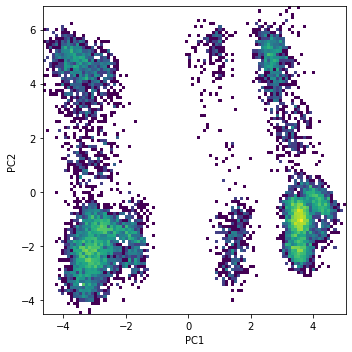

In [55]:
pca_fit_md = PCA(n_components=2)
dihed = dihedrals(xyz)
pca_fit_md.fit(dihed)
dihed = pca_fit_md.transform(dihed)

fig, axes = plt.subplots(figsize=(5,5))
plot_pcs(axes, dihed)
fig.tight_layout()
fig.show()
plt.savefig(f"figures/PCA_{nb_fname}_MD_7.png")

### Vacuum Trajectory

In [ ]:
filepath = f'/hits/basement/mcm/emmertme/Boltzmann/BG/Systems/{complex_name}/Peptides/{peptide_name}/vacuum'

traj_vacuum_md = md.load_pdb(os.path.join(filepath,'out_md.pdb'))

traj_vacuum_md.save(f'traj{nb_fname}_vacuum_md.h5')

In [ ]:
traj_vacuum_md=md.load_hdf5(f'traj{nb_fname}_vacuum_md.h5')

traj_KLL_no_GB=md.load_hdf5(f"bg_traj_KLL_no_GB_{nb_fname}.h5")

In [ ]:
#First run the dihedrals function
pca = PCA(n_components=2)
dihed = dihedrals(traj_vacuum_md.xyz)
pca.fit(dihed)
dihed = pca.transform(dihed)

fig, axes = plt.subplots(figsize=(5,5))
plot_pcs(axes, dihed)
fig.tight_layout()
fig.show()
plt.savefig(f"figures/PCA_{nb_fname}_vacuum_MD.png")

#First run the dihedrals function

dihed = dihedrals(traj_KLL_no_GB.xyz)
dihed = pca.transform(dihed)

fig, axes = plt.subplots(figsize=(5,5))
plot_pcs(axes, dihed)
fig.tight_layout()
fig.show()
plt.savefig(f"figures/PCA_{nb_fname}_vacuum_BG.png")

# Prepare Data

## Create Z-Matrix and assign (non-)gaussian torsions

In [56]:
zfactory = ZMatrixFactory(system.mdtraj_topology)

z_matrix, fixed_atoms = zfactory.build_with_templates()
#wird fuer die transformation von internen koordinaten (ICs) in kartesische Koordinaten  gebraucht.
#in jeder reihe: plaziere atom 1 besierend auf den kartesischen koordinaten der atome 2,3,4, sowie den ICs

FOLD_METHYL = False

#set if torsion is gaussian and if has to be shifted
with torch.no_grad():
    coordinate_transform = bg.GlobalInternalCoordinateTransformation(z_matrix)
    torsions_values = assert_numpy(coordinate_transform.forward(training_data)[2])
    if FOLD_METHYL:
        #set methyl groups. these are also trivial, but some are too uniform to be modelled as truncated gaussian
        is_methyl = bgmol.is_methyl_torsion(z_matrix, model.mdtraj_topology)
        torsions_values[:, is_methyl[3:]] = (torsions_values[:, is_methyl[3:]] % (1/3)) * 3 #fold the methyls
    n_torsions = torsions_values.shape[-1]


with warnings.catch_warnings():
    warnings.filterwarnings('ignore', message='p-value may not be accurate for N > 5000.')
    is_gaussian = np.full(n_torsions, False)
    is_tobe_shifted = np.full(n_torsions, False)
    for t in range(n_torsions):
        pvalue = shapiro(torsions_values[:,t])[1]
        if pvalue > 0:
            is_gaussian[t] = True
        else:
            pvalue = shapiro((torsions_values[:,t]+0.5)%1)[1]
            if pvalue > 0:
                is_tobe_shifted[t] = True

is_gaussian = np.append(np.full(3, False), is_gaussian) #add first three anchor points
is_tobe_shifted = np.append(np.full(3, False), is_tobe_shifted) #add first three anchor points
is_trivial = is_gaussian + is_tobe_shifted
n_trivialt = (is_trivial).sum()

if FOLD_METHYL:
    print('Tot methyl:', is_methyl.sum(), 'of which', np.logical_and(is_trivial, is_methyl).sum(), 'are gaussian')
print('Tot Gaussian:', is_gaussian.sum())
print('Tot Gaussian-if-shifted:', is_tobe_shifted.sum())
print('Tot trivial torsions:', n_trivialt)
z_matrix = np.vstack((z_matrix[~is_trivial], z_matrix[is_gaussian], z_matrix[is_tobe_shifted]))

Tot Gaussian: 35
Tot Gaussian-if-shifted: 9
Tot trivial torsions: 44


## Flow to shift gaussian to uniform distribution

In [57]:
def _assert_in_unit_interval(x):
    if (x > 1 + 1e-6).any() or (x < - 1e-6).any():
        raise ValueError(f'IncreaseMultiplicityFlow operates on [0,1] but input was {x}')

class CircularShiftFlow(Flow):
    """A flow that shifts the position of torsional degrees of freedom.
    The input and output tensors are expected to be in [0,1].
    The output is a translated version of the input, respecting circulariry.
    Parameters
    ----------
    shift : Union[torch.Tensor, float]
        A tensor that defines the translation of the circular interval
    """

    def __init__(self, shift):
        super().__init__()
        self.register_buffer("_shift", torch.as_tensor(shift))

    def _forward(self, x, **kwargs):
        _assert_in_unit_interval(x)
        y = (x + self._shift) % 1
        dlogp = torch.zeros_like(x[..., [0]])
        return y, dlogp

    def _inverse(self, x, **kwargs):
        _assert_in_unit_interval(x)
        y = (x - self._shift) % 1
        dlogp = torch.zeros_like(x[..., [0]])
        return y, dlogp

## Coordinate Transformation

In [58]:
ic = bg.GlobalInternalCoordinateTransformation(z_matrix) #internal coordinates

coordinate_transform = ic.to(**ctx)
constrained_indices, constrained_lengths = bgmol.bond_constraints(
    system.system,
    coordinate_transform
)
shape_info = ShapeDictionary.from_coordinate_transform(
    coordinate_transform,
    n_constraints=system.system.getNumConstraints()
)

torsions_shift = torch.zeros(n_torsions).to(**ctx)
torsions_shift[-is_tobe_shifted.sum():] = 0.5  #those to be shifted where placed at the end

prepareTorsions = CircularShiftFlow(torsions_shift)

#build marginal for trivial torsions
with torch.no_grad():
    torsions_values = coordinate_transform.forward(training_data)[2]
    trivial_torsions_values = prepareTorsions(torsions_values)[0][:,-n_trivialt:]
        
trivial_torsions_marginal = bg.TruncatedNormalDistribution(
    mu=trivial_torsions_values.mean(axis=0),
    sigma=trivial_torsions_values.std(axis=0),
    lower_bound=torch.tensor(0),
    upper_bound=torch.tensor(1)
).to(**ctx)
with torch.no_grad():
    print(trivial_torsions_marginal.sample(1).shape)

    

#md_data = torch.as_tensor(traj.xyz.reshape(-1,3*len(list(system.topology.atoms()))))
#bonds, angles, torsions, origin, rotation, dlogp = ic.forward(md_data)



NONTRIVIAL_TORSIONS = bg.TensorInfo(name='NONTRIVIAL_TORSIONS', is_circular=True)
TRIVIAL_TORSIONS = bg.TensorInfo(name='TRIVIAL_TORSIONS', is_circular=True)

shape_info.split(
    TORSIONS,
    into=(NONTRIVIAL_TORSIONS, TRIVIAL_TORSIONS),
    sizes=(n_torsions-n_trivialt, n_trivialt)
)

print(shape_info) #die shape info sagt dir, wie der latent space des BG aussehen soll. ( how many dimensions, circular or not.)

torch.Size([1, 44])
ShapeDictionary([(TensorInfo(name='BONDS', is_circular=False, is_cartesian=False), (26,)), (TensorInfo(name='ANGLES', is_circular=False, is_cartesian=False), (57,)), (TensorInfo(name='NONTRIVIAL_TORSIONS', is_circular=True, is_cartesian=False), (12,)), (TensorInfo(name='TRIVIAL_TORSIONS', is_circular=True, is_cartesian=False), (44,))])


In [59]:
z_matrix

array([[ 0, -1, -1, -1],
       [ 4,  0, -1, -1],
       [ 6,  4,  0, -1],
       [36, 28, 26, 24],
       [40, 38, 36, 28],
       [11,  8,  4,  0],
       [14, 11,  8,  4],
       [17, 14, 11,  8],
       [33, 30, 26, 24],
       [34, 33, 30, 26],
       [45, 42, 38, 36],
       [48, 45, 42, 38],
       [51, 48, 45, 42],
       [54, 51, 48, 45],
       [41, 40, 38, 36],
       [28, 26, 24,  6],
       [ 8,  4,  6,  0],
       [ 5,  4,  0,  6],
       [20, 17, 14, 11],
       [ 9,  8,  4, 11],
       [10,  8,  4, 11],
       [12, 11,  8, 14],
       [13, 11,  8, 14],
       [15, 14, 11, 17],
       [16, 14, 11, 17],
       [18, 17, 14, 20],
       [19, 17, 14, 20],
       [21, 20, 17, 14],
       [22, 20, 17, 21],
       [23, 20, 17, 22],
       [ 1,  0,  4,  6],
       [ 2,  0,  4,  1],
       [ 3,  0,  4,  1],
       [30, 26, 28, 24],
       [27, 26, 24, 28],
       [31, 30, 26, 33],
       [32, 30, 26, 33],
       [42, 38, 40, 36],
       [39, 38, 36, 40],
       [43, 42, 38, 45],


In [60]:
#z_translated = np.empty([59])
z_t = []
for row in z_matrix:
    row_translated = []
    for entry in row:
        row_translated.append(list(topology.atoms)[entry])
    z_t.append(row_translated)
z_t = np.array(z_t)

In [61]:
z_t

array([[LYS1-N, LYS3-OXT, LYS3-OXT, LYS3-OXT],
       [LYS1-CA, LYS1-N, LYS3-OXT, LYS3-OXT],
       [LYS1-C, LYS1-CA, LYS1-N, LYS3-OXT],
       [LYS3-N, ASP2-C, ASP2-CA, ASP2-N],
       [LYS3-C, LYS3-CA, LYS3-N, ASP2-C],
       [LYS1-CG, LYS1-CB, LYS1-CA, LYS1-N],
       [LYS1-CD, LYS1-CG, LYS1-CB, LYS1-CA],
       [LYS1-CE, LYS1-CD, LYS1-CG, LYS1-CB],
       [ASP2-CG, ASP2-CB, ASP2-CA, ASP2-N],
       [ASP2-OD1, ASP2-CG, ASP2-CB, ASP2-CA],
       [LYS3-CG, LYS3-CB, LYS3-CA, LYS3-N],
       [LYS3-CD, LYS3-CG, LYS3-CB, LYS3-CA],
       [LYS3-CE, LYS3-CD, LYS3-CG, LYS3-CB],
       [LYS3-NZ, LYS3-CE, LYS3-CD, LYS3-CG],
       [LYS3-O, LYS3-C, LYS3-CA, LYS3-N],
       [ASP2-C, ASP2-CA, ASP2-N, LYS1-C],
       [LYS1-CB, LYS1-CA, LYS1-C, LYS1-N],
       [LYS1-HA, LYS1-CA, LYS1-N, LYS1-C],
       [LYS1-NZ, LYS1-CE, LYS1-CD, LYS1-CG],
       [LYS1-HB2, LYS1-CB, LYS1-CA, LYS1-CG],
       [LYS1-HB3, LYS1-CB, LYS1-CA, LYS1-CG],
       [LYS1-HG2, LYS1-CG, LYS1-CB, LYS1-CD],
       [LYS1-HG3, LYS1-

In [62]:
list(topology.atoms)

[LYS1-N,
 LYS1-H,
 LYS1-H2,
 LYS1-H3,
 LYS1-CA,
 LYS1-HA,
 LYS1-C,
 LYS1-O,
 LYS1-CB,
 LYS1-HB2,
 LYS1-HB3,
 LYS1-CG,
 LYS1-HG2,
 LYS1-HG3,
 LYS1-CD,
 LYS1-HD2,
 LYS1-HD3,
 LYS1-CE,
 LYS1-HE2,
 LYS1-HE3,
 LYS1-NZ,
 LYS1-HZ1,
 LYS1-HZ2,
 LYS1-HZ3,
 ASP2-N,
 ASP2-H,
 ASP2-CA,
 ASP2-HA,
 ASP2-C,
 ASP2-O,
 ASP2-CB,
 ASP2-HB2,
 ASP2-HB3,
 ASP2-CG,
 ASP2-OD1,
 ASP2-OD2,
 LYS3-N,
 LYS3-H,
 LYS3-CA,
 LYS3-HA,
 LYS3-C,
 LYS3-O,
 LYS3-CB,
 LYS3-HB2,
 LYS3-HB3,
 LYS3-CG,
 LYS3-HG2,
 LYS3-HG3,
 LYS3-CD,
 LYS3-HD2,
 LYS3-HD3,
 LYS3-CE,
 LYS3-HE2,
 LYS3-HE3,
 LYS3-NZ,
 LYS3-HZ1,
 LYS3-HZ2,
 LYS3-HZ3,
 LYS3-OXT]

# Investigate Structure

# Calculate Distances between interesting atoms and compare

The following 3 atom pairs either show interactions (LYS3-O and LYS1-NZ; ASP2-OD2 and LYS1-NZ) or are relevant to investigate the overall structure of the samples (LYS3-NZ and LYS1-NZ) as they both are on opposite ends of the peptide, and therefore show how stretched it is.

In [34]:
#calculate distances between two specific atoms for each frame
def dist_atoms(traj, atom1, atom2):
    distances = []
    for frame in range(0,traj.n_frames):
        xyz = traj.xyz
        a = xyz[frame,atom1,:] #np.ndarray, shape=(n_frames, n_atoms, 3)
        b = xyz[frame,atom2,:]
        dist = np.linalg.norm(a-b)*10
        distances.append(dist)
    distances = np.array(distances)

    #mean = np.mean(distances)
    #std = np.std(distances)
    return distances #mean, std

In [ ]:
#Barplot
plt.bar(range(len(dist_values)), dist_values, align='center', yerr=std_values)
plt.xticks(range(len(dist_values)), keys)
ax = plt.gca()
#ax.set_ylim([-1000, 4000])
max_y_lim = max(dist_values) + max(std_values) + 0.1
min_y_lim = min(dist_values) - max(std_values) - 0.1
plt.ylim(min_y_lim, max_y_lim)
plt.ylabel('Distance LYS3-O and LYS1-NZ [Å]')
#ax.set_yscale('symlog')
plt.xticks(rotation=90)
#plt.savefig(f"figures/Dist_LYS3-O_LYS1-NZ_{nb_fname}_Comp.png", bbox_inches="tight")
plt.show()

## LYS3-O and LYS1-NZ (interaction)

/tmp/ipykernel_16350/2914853800.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(keys)


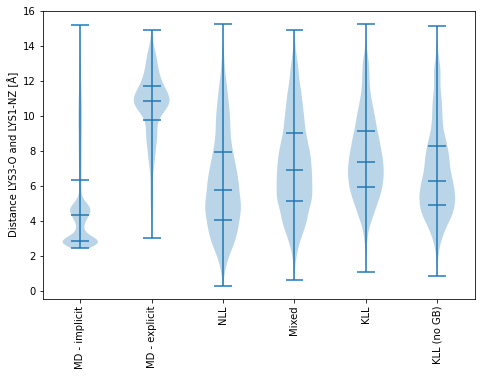

Ttest_indResult(statistic=-83.62148070041668, pvalue=0.0)


In [60]:
# Calculate distance between LYS3-O and LYS1-NZ
atom_1 = 41
atom_2 = 20
dist_MD_impl = dist_atoms(traj, atom_1, atom_2)

dist_MD_expl = dist_atoms(expl_traj, atom_1, atom_2)

dist_NLL = dist_atoms(traj_NLL, atom_1, atom_2)

dist_Mixed = dist_atoms(traj_Mixed, atom_1, atom_2)

dist_KLL = dist_atoms(traj_KLL, atom_1, atom_2)

dist_KLL_no_GB = dist_atoms(traj_KLL_no_GB, atom_1, atom_2)

keys = ["o", "MD - implicit", "MD - explicit", "NLL", "Mixed", "KLL", "KLL (no GB)"]

dist_values = [dist_MD_impl, dist_MD_expl, dist_NLL, dist_Mixed, dist_KLL, dist_KLL_no_GB]


# Plot in Boxplot
fig = plt.figure()
 
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
ax.set_xticklabels(keys)
 
# Creating plot
bp = ax.violinplot(dist_values, showmedians=True, showextrema=True, quantiles=[(0.25, 0.75), (0.25, 0.75), (0.25, 0.75), (0.25, 0.75), (0.25, 0.75),(0.25, 0.75)])

plt.xticks(rotation=90)
plt.ylabel('Distance LYS3-O and LYS1-NZ [Å]')

plt.savefig(f"figures/Dist_LYS3-O_LYS1-NZ_{nb_fname}_Comp.png", bbox_inches="tight")
plt.show()

#Performing a 2-sided t-test on the data
test = scipy.stats.ttest_ind(dist_MD_impl, dist_KLL)
print(test)

## ASP2-OD2 and LYS1-NZ (interaction)

/tmp/ipykernel_16350/3682839620.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(keys)


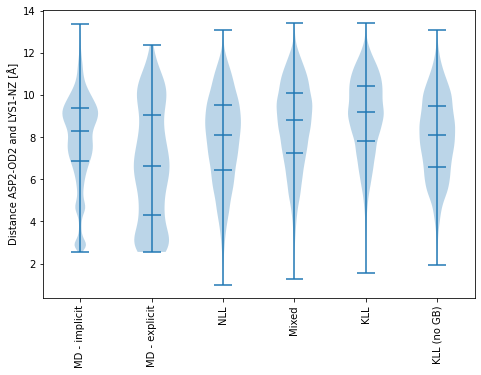

Ttest_indResult(statistic=-52.13439377646338, pvalue=0.0)


In [62]:
# Calculate distance between ASP2-OD2 and LYS1-NZ
atom_1 = 34
atom_2 = 20
dist_MD_impl = dist_atoms(traj, atom_1, atom_2)

dist_MD_expl = dist_atoms(expl_traj, atom_1, atom_2)

dist_NLL = dist_atoms(traj_NLL, atom_1, atom_2)

dist_Mixed = dist_atoms(traj_Mixed, atom_1, atom_2)

dist_KLL = dist_atoms(traj_KLL, atom_1, atom_2)

dist_KLL_no_GB = dist_atoms(traj_KLL_no_GB, atom_1, atom_2)

keys = ["o", "MD - implicit", "MD - explicit", "NLL", "Mixed", "KLL", "KLL (no GB)"]

dist_values = [dist_MD_impl, dist_MD_expl, dist_NLL, dist_Mixed, dist_KLL, dist_KLL_no_GB]


# Plot in Boxplot
fig = plt.figure()
 
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
ax.set_xticklabels(keys)
 
# Creating plot
bp = ax.violinplot(dist_values, showmedians=True, showextrema=True, quantiles=[(0.25, 0.75), (0.25, 0.75), (0.25, 0.75), (0.25, 0.75), (0.25, 0.75),(0.25, 0.75)])

plt.xticks(rotation=90)
plt.ylabel('Distance ASP2-OD2 and LYS1-NZ [Å]')

plt.savefig(f"figures/Dist_ASP2-OD2_LYS1-NZ_{nb_fname}_Comp.png", bbox_inches="tight")
plt.show()

#Performing a 2-sided t-test on the data
test = scipy.stats.ttest_ind(dist_MD_impl, dist_KLL)
print(test)

## LYS1-NZ and LYS3-NZ (opposite ends)

/tmp/ipykernel_16350/3449082495.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(keys)


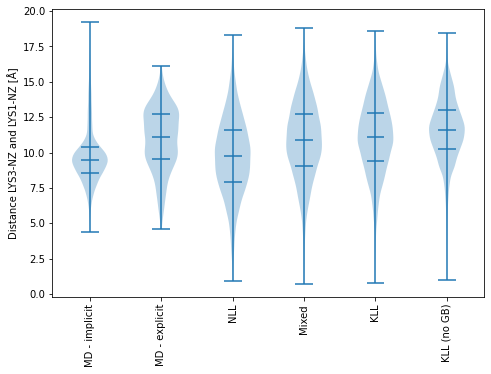

Ttest_indResult(statistic=-65.73549773174251, pvalue=0.0)


In [65]:
# Calculate distance between LYS3-NZ and LYS1-NZ
atom_1 = 54
atom_2 = 20
dist_MD_impl = dist_atoms(traj, atom_1, atom_2)

dist_MD_expl = dist_atoms(expl_traj, atom_1, atom_2)

dist_NLL = dist_atoms(traj_NLL, atom_1, atom_2)

dist_Mixed = dist_atoms(traj_Mixed, atom_1, atom_2)

dist_KLL = dist_atoms(traj_KLL, atom_1, atom_2)

dist_KLL_no_GB = dist_atoms(traj_KLL_no_GB, atom_1, atom_2)

keys = ["o", "MD - implicit", "MD - explicit", "NLL", "Mixed", "KLL", "KLL (no GB)"]

dist_values = [dist_MD_impl, dist_MD_expl, dist_NLL, dist_Mixed, dist_KLL, dist_KLL_no_GB]


# Plot in Boxplot
fig = plt.figure()
 
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
ax.set_xticklabels(keys)
 
# Creating plot
bp = ax.violinplot(dist_values, showmedians=True, showextrema=True, quantiles=[(0.25, 0.75), (0.25, 0.75), (0.25, 0.75), (0.25, 0.75), (0.25, 0.75),(0.25, 0.75)])

plt.xticks(rotation=90)
plt.ylabel('Distance LYS3-NZ and LYS1-NZ [Å]')

plt.savefig(f"figures/Dist_LYS3-NZ_LYS1-NZ_{nb_fname}_Comp.png", bbox_inches="tight")
plt.show()

#Performing a 2-sided t-test on the data
test = scipy.stats.ttest_ind(dist_MD_impl, dist_KLL)
print(test)

# Compare Torsions in a Ramachandran Plot

In [35]:
#calculate distances between two specific atoms for each frame
def dihed_torsions(traj, torsion1, torsion2):
    dihedrals = []
    for frame in range(0,traj.n_frames):
        
        diheds = md.compute_dihedrals(traj, dihedral_indices)
        
        dihedrals.append(dihed)
    dihedrals = np.array(dihed)
    
    mean = np.mean(distances)
    std = np.std(distances)
    
    return distances #mean, std

## Torsion 56 [LYS3-OXT, LYS3-C, LYS3-CA, LYS3-O] and 8 [LYS3-NZ, LYS3-CE, LYS3-CD, LYS3-CG]

In [ ]:
#MD
R = md.compute_dihedrals(traj, [[58, 40, 38, 41],[20, 17, 14, 11]])
R = np.degrees(R)

plt.figure()
plt.hist2d(R[:, 0], R[:,1], bins=100, density=True, norm=mpl.colors.LogNorm())
plt.xlabel('Ψ')
plt.ylabel('Φ')
plt.title('Ramachandran Plot: 1b4z - MD')
cbar = plt.colorbar()
cbar.set_label('log(10 000 samples)')
plt.savefig(f"figures/Tors_56_8_{nb_fname}_MD.png", bbox_inches="tight")
plt.show()


#NLL
R = md.compute_dihedrals(traj_NLL, [[58, 40, 38, 41],[20, 17, 14, 11]])
R = np.degrees(R)

plt.figure()
plt.hist2d(R[:, 0], R[:,1], bins=100, density=True, norm=mpl.colors.LogNorm())
plt.xlabel('Ψ')
plt.ylabel('Φ')
plt.title('Ramachandran Plot: 1b4z - NLL')
cbar = plt.colorbar()
cbar.set_label('log(10 000 samples)')
plt.savefig(f"figures/Tors_56_8_{nb_fname}_NLL.png", bbox_inches="tight")
plt.show()

#KLL
R = md.compute_dihedrals(traj_KLL, [[58, 40, 38, 41],[20, 17, 14, 11]])
R = np.degrees(R)

plt.figure()
plt.hist2d(R[:, 0], R[:,1], bins=100, density=True, norm=mpl.colors.LogNorm())
plt.xlabel('Ψ')
plt.ylabel('Φ')
plt.title('Ramachandran Plot: 1b4z - KLL')
cbar = plt.colorbar()
cbar.set_label('log(10 000 samples)')
plt.savefig(f"figures/Tors_56_8_{nb_fname}_KLL.png", bbox_inches="tight")
plt.show()


#KLL (no GB)
R = md.compute_dihedrals(traj_KLL_no_GB, [[58, 40, 38, 41],[20, 17, 14, 11]])
R = np.degrees(R)

plt.figure()
plt.hist2d(R[:, 0], R[:,1], bins=100, density=True, norm=mpl.colors.LogNorm())
plt.xlabel('Ψ')
plt.ylabel('Φ')
plt.title('Ramachandran Plot: 1b4z - KLL (no GB)')
cbar = plt.colorbar()
cbar.set_label('log(10 000 samples)')
plt.savefig(f"figures/Tors_56_8_{nb_fname}_KLL_no_GB.png", bbox_inches="tight")
plt.show()

## Torsion [18, 17, 14, 20] and 6 [LYS1-CD, LYS1-CG, LYS1-CB, LYS1-CA]

In [ ]:
#MD
R = md.compute_dihedrals(traj, [[18, 17, 14, 20],[14, 11,  8,  4]])
R = np.degrees(R)

plt.figure()
plt.hist2d(R[:, 0], R[:,1], bins=100, density=True, norm=mpl.colors.LogNorm())
plt.xlabel('Ψ')
plt.ylabel('Φ')
plt.title('Ramachandran Plot: 1b4z - MD')
cbar = plt.colorbar()
cbar.set_label('log(10 000 samples)')
plt.savefig(f"figures/Tors_56_6_{nb_fname}_MD.png", bbox_inches="tight")
plt.show()


#NLL
R = md.compute_dihedrals(traj_NLL, [[18, 17, 14, 20],[14, 11,  8,  4]])
R = np.degrees(R)

plt.figure()
plt.hist2d(R[:, 0], R[:,1], bins=100, density=True, norm=mpl.colors.LogNorm())
plt.xlabel('Ψ')
plt.ylabel('Φ')
plt.title('Ramachandran Plot: 1b4z - NLL')
cbar = plt.colorbar()
cbar.set_label('log(10 000 samples)')
plt.savefig(f"figures/Tors_56_6_{nb_fname}_NLL.png", bbox_inches="tight")
plt.show()

#KLL
R = md.compute_dihedrals(traj_KLL, [[18, 17, 14, 20],[14, 11,  8,  4]])
R = np.degrees(R)

plt.figure()
plt.hist2d(R[:, 0], R[:,1], bins=100, density=True, norm=mpl.colors.LogNorm())
plt.xlabel('Ψ')
plt.ylabel('Φ')
plt.title('Ramachandran Plot: 1b4z - KLL')
cbar = plt.colorbar()
cbar.set_label('log(10 000 samples)')
plt.savefig(f"figures/Tors_56_6_{nb_fname}_KLL.png", bbox_inches="tight")
plt.show()


#KLL (no GB)
R = md.compute_dihedrals(traj_KLL_no_GB, [[18, 17, 14, 20],[14, 11,  8,  4]])
R = np.degrees(R)

plt.figure()
plt.hist2d(R[:, 0], R[:,1], bins=100, density=True, norm=mpl.colors.LogNorm())
plt.xlabel('Ψ')
plt.ylabel('Φ')
plt.title('Ramachandran Plot: 1b4z - KLL (no GB)')
cbar = plt.colorbar()
cbar.set_label('log(10 000 samples)')
plt.savefig(f"figures/Tors_56_6_{nb_fname}_KLL_no_GB.png", bbox_inches="tight")
plt.show()

# Build the BG

In [63]:
builder = BoltzmannGeneratorBuilder(shape_info, target_energy, **ctx)

# first, work on torsions, as they are the hardest part
t1, t2 = builder.add_split(
    NONTRIVIAL_TORSIONS,
    into=["T1", "T2"],
    sizes_or_indices=[shape_info[NONTRIVIAL_TORSIONS][0]//2,shape_info[NONTRIVIAL_TORSIONS][0] - shape_info[NONTRIVIAL_TORSIONS][0]//2],
    #sizes_or_indices=[np.arange(0,7,2), np.arange(1,7,2)]
)
for i in range(6):
    builder.add_condition(t1, on=t2,
                          #hidden=(512,512)
                         )
    builder.add_condition(t2, on=t1,
                          #hidden=(512,512)
                         )
builder.add_merge(
    (t1, t2),
    to=NONTRIVIAL_TORSIONS,
    sizes_or_indices=[shape_info[NONTRIVIAL_TORSIONS][0]//2,shape_info[NONTRIVIAL_TORSIONS][0] - shape_info[NONTRIVIAL_TORSIONS][0]//2],
)
t1, t2 = builder.add_split(
    TRIVIAL_TORSIONS,
    into=["T1", "T2"],
    sizes_or_indices=[shape_info[TRIVIAL_TORSIONS][0]//2,shape_info[TRIVIAL_TORSIONS][0] - shape_info[TRIVIAL_TORSIONS][0]//2],
    #sizes_or_indices=[np.arange(0,7,2), np.arange(1,7,2)]
)
for i in range(6):
    builder.add_condition(t1, on=(t2,NONTRIVIAL_TORSIONS)
                          #hidden=(512,512)
                         )
    builder.add_condition(t2, on=(t1,NONTRIVIAL_TORSIONS)
                          #hidden=(512,512)
                         )
builder.add_merge(
    (t1, t2),
    to=TRIVIAL_TORSIONS,
    sizes_or_indices=[shape_info[TRIVIAL_TORSIONS][0]//2,shape_info[TRIVIAL_TORSIONS][0] - shape_info[TRIVIAL_TORSIONS][0]//2],
)



# then, do angles and bonds
a1, a2 = builder.add_split(
    ANGLES,
    into=["A1", "A2"],
    sizes_or_indices=[shape_info[ANGLES][0]//2,shape_info[ANGLES][0] - shape_info[ANGLES][0]//2],
)
for i in range(4):
    builder.add_condition(a1, on=[a2, NONTRIVIAL_TORSIONS, TRIVIAL_TORSIONS],
                          #hidden=(512,512)
                         )
    builder.add_condition(a2, on=[a1, NONTRIVIAL_TORSIONS, TRIVIAL_TORSIONS],
                          #hidden=(512,512)
                         )
builder.add_merge(
    (a1, a2),
    to=ANGLES,
    sizes_or_indices=[shape_info[ANGLES][0]//2,shape_info[ANGLES][0] - shape_info[ANGLES][0]//2],
)

b1, b2 = builder.add_split(
    BONDS,
    into=["B1", "B2"],
    sizes_or_indices=[shape_info[BONDS][0]//2,shape_info[BONDS][0] - shape_info[BONDS][0]//2],
)
for i in range(4):
    builder.add_condition(b1, on=[b2, ANGLES, NONTRIVIAL_TORSIONS, TRIVIAL_TORSIONS],
                      spline    #hidden=(512,512)
                         )
    builder.add_condition(b2, on=[b1, ANGLES, NONTRIVIAL_TORSIONS, TRIVIAL_TORSIONS],
                          #hidden=(512,512)
                         )
builder.add_merge(
    (b1, b2),
    to=BONDS,
    sizes_or_indices=[shape_info[BONDS][0]//2,shape_info[BONDS][0] - shape_info[BONDS][0]//2],
)
cdfs = InternalCoordinateMarginals( #Annahmen der cumulative density function
    builder.current_dims,
    builder.ctx,
    bonds=BONDS,
    angles=ANGLES,
    torsions=None,#TORSIONS,
    fixed=None,
    bond_mu=0.2,
    bond_sigma=2.0,
    bond_upper=1.0,
    bond_lower=0.03,
    #angle_mu=0.7,
    angle_lower=0.1,
    angle_upper=0.9
)
cdfs.inform_with_data(torch.tensor(xyz[:1000], **ctx).reshape(1000, -1), coordinate_transform ,
                      constrained_bond_indices = bond_constraints(system.system, coordinate_transform)[0]) #inform_with_data updatet die Annahme mit der marginal_distribution


cdfs[TRIVIAL_TORSIONS] = trivial_torsions_marginal
icdf_maps = builder.add_map_to_ic_domains(cdfs, return_layers=True)

builder.add_merge([NONTRIVIAL_TORSIONS, TRIVIAL_TORSIONS], to=TORSIONS)
fmod_layer = CircularShiftFlow(torsions_shift).to(**ctx)
builder.add_layer(fmod_layer,what=(TORSIONS, ))


builder.add_merge_constraints(*bond_constraints(system.system, coordinate_transform))
builder.add_map_to_cartesian(coordinate_transform)


#generator = builder.build_generator(zero_parameters=False)
generator = builder.build_generator()

In [66]:
print('parameters:', sum([np.prod(p.shape) for p in generator.parameters()]))

generator.sample(10).shape
generator.energy(training_data[:10,...])
#check if it works without error

parameters: 3229676


tensor([[-391.1499],
        [-402.6933],
        [-418.2735],
        [-425.1191],
        [-384.6208],
        [-406.7189],
        [-396.5000],
        [-413.7306],
        [-377.9707],
        [-398.5878]], grad_fn=<SubBackward0>)

## NLL Training

In [67]:
# train using only training by Example

full_nll_optimizer = torch.optim.Adam(generator.parameters(), lr=1e-4)
full_nll_trainer = bg.KLTrainer(
    generator, 
    optim=full_nll_optimizer,
    train_energy=False,
    test_likelihood = True
)

if True:
    generator.train(True)
    full_nll_trainer.train(
        n_iter=2000, 
        data=training_data,
        testdata = test_data,
        batchsize=1024,
        n_print=100, 
        w_energy=0.0
    )
    generator.train(False)

1	NLL: -406.6158	NLL(Test): -405.3649	
101	NLL: -444.2203	NLL(Test): -439.2072	
201	NLL: -457.0344	NLL(Test): -448.9222	
301	NLL: -463.5532	NLL(Test): -452.0692	
401	NLL: -468.2935	NLL(Test): -451.8835	
501	NLL: -472.0149	NLL(Test): -449.9819	
601	NLL: -476.3401	NLL(Test): -447.1548	
701	NLL: -481.4434	NLL(Test): -443.5732	
801	NLL: -485.7706	NLL(Test): -439.5990	
901	NLL: -490.4266	NLL(Test): -435.0004	
1001	NLL: -493.6621	NLL(Test): -431.2660	
1101	NLL: -496.9910	NLL(Test): -427.4939	
1201	NLL: -499.3605	NLL(Test): -424.5389	
1301	NLL: -502.3722	NLL(Test): -421.7563	
1401	NLL: -504.3394	NLL(Test): -419.4490	
1501	NLL: -506.3523	NLL(Test): -416.9669	
1601	NLL: -507.5581	NLL(Test): -415.3112	
1701	NLL: -508.7343	NLL(Test): -413.3706	
1801	NLL: -508.2344	NLL(Test): -411.9688	
1901	NLL: -512.7109	NLL(Test): -412.0921	


In [73]:
nb_fname = ipynbname.name()
nb_path = ipynbname.path()

#torch.save(generator.state_dict(), f"models/{nb_fname}_NLL_{peptide_name}_7.pic")

generator.load_state_dict(torch.load(f"models/{nb_fname}_NLL_{peptide_name}_7.pic"))

<All keys matched successfully>

## Mixed Training

In [69]:
#combined training of training by example and a little bit training by energy

#we have found a way to make training by energy work better: 
#when calculating the reverse KL Diveregence ( the Training by Energy Loss), you discard the worst of the samples
#exactly how many samples to discard is a bit hacky, it depends on how good your samples are in the first place.
#here we train on the better 90%

#hier geben die Loss-werte nicht wirklich aufschuss über den training progress. mit diesem training-procedure
#werden die samples aber besser, wie man weiter unter sehen kann (energy plots).

def quantile_truncated_energy_loss(batch_size = 32, quantile = 0.5):
    kld = generator.kldiv(batch_size)
    lower = kld <= kld.quantile(quantile)
    loss = kld[lower].mean()
    #bp()
    return(loss)

mixed_optimizer = torch.optim.Adam(generator.parameters(), lr=1e-4)
mixed_trainer = bg.KLTrainer(
    generator, 
    optim=mixed_optimizer,
    train_energy=True,
    custom_loss = quantile_truncated_energy_loss
)

loss_names = ["KLL", "NLL", "truncated_energy_loss"]


mixed_trainer.reporter = bg.LossReporter(*loss_names)

#mixed_trainer.reporter._n_reported = 3

if True:
    generator.train(True)
    mixed_trainer.train(
        n_iter=600, 
        data=training_data,
        batchsize=32,#128
        n_print=10, 
        w_energy=0.,
        w_custom = 0.8,
        w_likelihood = 0.2,
        custom_loss_kwargs = {"batch_size": 32,
                              "quantile": 0.9},
        clip_forces=None
    )
    generator.train(False)


1	KLL: 1667.4419	NLL: -506.8670	truncated_energy_loss: 208.4910	
11	KLL: 7113332.5000	NLL: -469.4449	truncated_energy_loss: 200.0505	
21	KLL: 134844.7188	NLL: -468.5939	truncated_energy_loss: 158.1974	
31	KLL: 222.9704	NLL: -463.5547	truncated_energy_loss: 155.5924	
41	KLL: 371.9162	NLL: -468.0863	truncated_energy_loss: 161.7381	
51	KLL: 82970.7500	NLL: -462.8395	truncated_energy_loss: 156.4248	
61	KLL: 216553.9375	NLL: -463.0331	truncated_energy_loss: 163.9211	
71	KLL: 251.8653	NLL: -448.6688	truncated_energy_loss: 159.8269	
81	KLL: 247.5016	NLL: -440.9810	truncated_energy_loss: 165.6754	
91	KLL: 173.1043	NLL: -436.2428	truncated_energy_loss: 163.4012	
101	KLL: 19813740544.0000	NLL: -443.7574	truncated_energy_loss: 171.4279	
111	KLL: 1582.1353	NLL: -445.4992	truncated_energy_loss: 173.4960	
121	KLL: 2735.4785	NLL: -442.0645	truncated_energy_loss: 167.2038	
131	KLL: 182.2101	NLL: -448.1594	truncated_energy_loss: 166.1085	
141	KLL: 208.3765	NLL: -453.5560	truncated_energy_loss: 163.6444

In [70]:
nb_fname = ipynbname.name()
nb_path = ipynbname.path()

torch.save(generator.state_dict(), f"models/{nb_fname}_Mixed_{peptide_name}_7.pic")

generator.load_state_dict(torch.load(f"models/{nb_fname}_Mixed_{peptide_name}_7.pic"))

<All keys matched successfully>

## KLL Training

In [71]:
# now we drop the NLL loss completely

if True:
    generator.train(True)
    mixed_trainer.train(
        n_iter=3000, 
        data=training_data,
        batchsize=32,#128
        n_print=100, 
        w_energy=0.,
        w_custom = 0.8,
        w_likelihood = 0,
        custom_loss_kwargs = {"batch_size": 32,
                              "quantile": 0.9},
        clip_forces=None
    )
    generator.train(False)


601	KLL: 168.8694	NLL: -467.0201	truncated_energy_loss: 164.5789	
701	KLL: 1535.1821	NLL: -446.6997	truncated_energy_loss: 149.9978	
801	KLL: 17106484.0000	NLL: -450.6869	truncated_energy_loss: 143.2460	
901	KLL: 170.2335	NLL: -451.8368	truncated_energy_loss: 147.4254	
1001	KLL: 169.4028	NLL: -452.7115	truncated_energy_loss: 141.9659	
1101	KLL: 219.1339	NLL: -440.6626	truncated_energy_loss: 146.6777	
1201	KLL: 179.2226	NLL: -445.4303	truncated_energy_loss: 152.6378	
1301	KLL: 414.5556	NLL: -448.0655	truncated_energy_loss: 144.8423	
1401	KLL: 141.5914	NLL: -449.7064	truncated_energy_loss: 136.3001	
1501	KLL: 747.2792	NLL: -451.3298	truncated_energy_loss: 131.9475	
1601	KLL: 136.3854	NLL: -447.6237	truncated_energy_loss: 133.7211	
1701	KLL: 148.1415	NLL: -448.2540	truncated_energy_loss: 131.8294	
1801	KLL: 131.0416	NLL: -445.9835	truncated_energy_loss: 129.4410	
1901	KLL: 191.5538	NLL: -449.2817	truncated_energy_loss: 131.1925	
2001	KLL: 136.6597	NLL: -451.3735	truncated_energy_loss: 126

In [72]:
nb_fname = ipynbname.name()
nb_path = ipynbname.path()

torch.save(generator.state_dict(), f"models/{nb_fname}_KLL_{peptide_name}_7.pic")

generator.load_state_dict(torch.load(f"models/{nb_fname}_KLL_{peptide_name}_7.pic"))

<All keys matched successfully>

## KLL (no GB)

In [ ]:
### nach diesem training haben wir schöne energies, aber beim genauen hinsehen merken wir,
### dass die nonbonded energies immer noch nicht so super sind, das wird lediglich durch den GB-Term kompensiert (implicit solvent)

### wir versuchen mal, die nonbonded terms weiter zu optimieren:
#dazu nehmen wir den GB-Term aus der Energiefunktion heraus

#limiting the values that the energy can reach makes training more stable.
CutTarget = LinLogCutEnergy(target_energy)

generator._target = CutTarget

generator._target.delegate._bridge.context_wrapper._system.getForces()
#GB_force = generator._target.delegate._bridge.context_wrapper._system.getForce(4)
generator._target.delegate._bridge.context_wrapper._system.removeForce(4)

In [ ]:
mixed_optimizer = torch.optim.Adam(generator.parameters(), lr=1e-4)
mixed_trainer = bg.KLTrainer(
    generator, 
    optim=mixed_optimizer,
    train_energy=True,
    custom_loss = quantile_truncated_energy_loss
)

loss_names = ["KLL", "NLL", "truncated_energy_loss"]


mixed_trainer.reporter = bg.LossReporter(*loss_names)

if True:
    generator.train(True)
    mixed_trainer.train(
        n_iter=3000, 
        data=training_data,
        batchsize=32,#128
        n_print=10, 
        w_energy=0.,
        w_custom = 0.8,
        w_likelihood = 0,
        custom_loss_kwargs = {"batch_size": 32,
                              "quantile": 0.9},
        clip_forces=None
    )
    generator.train(False)


In [31]:
## now for the evaluation we add the force again:
#generator._target.delegate._bridge.context_wrapper._system.addForce(GB_force)
#this doesnt work so we have to rebuild the generator and load the state dict

nb_fname = ipynbname.name()
nb_path = ipynbname.path()

#torch.save(generator.state_dict(), f"models/{nb_fname}_KLL_no_GB_{peptide_name}.pic")
generator.load_state_dict(torch.load(f"models/{nb_fname}_KLL_no_GB_{peptide_name}.pic"))
#generator._target._bridge._openmm_system.getForces()#__dict__#.context_wrapper.__dict__

CutTarget = LinLogCutEnergy(generator._target)
sum([np.prod(p.shape) for p in generator.parameters()])

3248108

# Evaluate

In [74]:
generator._target
#generator._target._bridge.context_wrapper
#generator._target._bridge.__dict__
generator._target = system._energy_model


for force in range(len(system.system.getForces())):
    system.system.getForces()[force].setForceGroup(force)

system.reinitialize_energy_model(temperature=300, platform_name="CPU", n_workers = 1)
target_real = system._energy_model

NUM_SAMPLES = 3

positions = test_data[:NUM_SAMPLES].reshape(NUM_SAMPLES, -1, 3)

#target_real._bridge.context_wrapper
#generator._target._bridge._openmm_system
Context = target_real._bridge.context_wrapper._openmm_context
#Context = generator._target._bridge._openmm_system
print(Context.getPlatform().getName())

p = positions[0]

p=p.to('cpu').numpy()


Context.setPositions(p)

state = Context.getState(
                    getEnergy=True,
                    getForces=False,
                    getPositions=False)
UNIT = state.getPotentialEnergy().unit

kbT = target_real._bridge._reduce_units



print(shape_info)

Context.getSystem().getForces()

CPU
ShapeDictionary([(TensorInfo(name='BONDS', is_circular=False, is_cartesian=False), (26,)), (TensorInfo(name='ANGLES', is_circular=False, is_cartesian=False), (57,)), (TensorInfo(name='NONTRIVIAL_TORSIONS', is_circular=True, is_cartesian=False), (12,)), (TensorInfo(name='TRIVIAL_TORSIONS', is_circular=True, is_cartesian=False), (44,))])


[<openmm.openmm.HarmonicBondForce; proxy of <Swig Object of type 'OpenMM::HarmonicBondForce *' at 0x7f266de2be70> >,
 <openmm.openmm.HarmonicAngleForce; proxy of <Swig Object of type 'OpenMM::HarmonicAngleForce *' at 0x7f266de290b0> >,
 <openmm.openmm.PeriodicTorsionForce; proxy of <Swig Object of type 'OpenMM::PeriodicTorsionForce *' at 0x7f266fe70270> >,
 <openmm.openmm.NonbondedForce; proxy of <Swig Object of type 'OpenMM::NonbondedForce *' at 0x7f266fe70480> >,
 <openmm.openmm.CMMotionRemover; proxy of <Swig Object of type 'OpenMM::CMMotionRemover *' at 0x7f2676118b40> >,
 <openmm.openmm.CustomGBForce; proxy of <Swig Object of type 'OpenMM::CustomGBForce *' at 0x7f266e272430> >]

In [75]:
with open(f"metrics/{nb_fname}_NLL_{peptide_name}_7.pic", 'w+') as f:
    with redirect_stdout(f):
        NUM_SAMPLES = 10000
        BATCHSIZE = 32
        #generator_metrics(generator, valdata = valdata[:10000])
        ## MD samples
        
        energies = {}
        quants = []
        for q in range(9):
            quants.append(openmm.unit.quantity.Quantity(unit = UNIT))
        #quants = [openmm.unit.quantity.Quantity(unit = UNIT)]*7
        names = ["Bonds","Angles","Torsion","Nonbonded","CMMremover", "GB"]
        for q,n in zip(quants,names):
            energies[n] = q
        
        
        #
        #data_native = data[:NUM_SAMPLES]
        #
        #positions,_ = data_native.reshape(NUM_SAMPLES,-1,3)
        
        n_batches = NUM_SAMPLES//BATCHSIZE
        #for i in range(n_batches):
         #   positions_batch = generator.sample(1000).cpu().detach().reshape(1000,-1,3).numpy()
         #   positions
        
        positions = test_data[:NUM_SAMPLES].reshape(NUM_SAMPLES,-1,3)
        
        for p in tqdm(positions):
            Context.setPositions(p.cpu().numpy())
            for i, (q, n) in enumerate(zip(quants,names)):
                #ipdb.set_trace()
                state = Context.getState(
                                getEnergy=True,
                                getForces=False,
                                getPositions=False,
                                groups = {i})
                #ipdb.set_trace()
                energies[n].append(state.getPotentialEnergy())
        
        #for key in energies:
        #    print(f"{key}: {energies[key].mean()}")
        print("*****MD-Data*****")
        resdict_MD = {}
        for key in energies:
            val = kbT(np.array(energies[key]._value))
            print(f"{key}: {val}")
            resdict_MD[key] = val

######### de-novo samples
        
        
        energies = {}
        quants = []
        for q in range(9):
            quants.append(openmm.unit.quantity.Quantity(unit = UNIT))
        #quants = [openmm.unit.quantity.Quantity(unit = UNIT)]*7
        for q,n in zip(quants,names):
            energies[n] = q
        
        
        #
        #data_native = data[:NUM_SAMPLES]
        #
        #positions,_ = data_native.reshape(NUM_SAMPLES,-1,3)
        
        n_batches = NUM_SAMPLES//BATCHSIZE
        #for i in range(n_batches):
         #   positions_batch = generator.sample(1000).cpu().detach().reshape(1000,-1,3).numpy()
         #   positions
        pos = []
        #B, A, T, BB, c1, C2, C3, C4, j = generator.flow(torch.Tensor(valdata[:BATCHSIZE]).to(ctx["device"]), inverse = True)
        for _ in tqdm(range(n_batches)):


            zB, zA, znT, ztT = generator.prior.sample(BATCHSIZE)
            #bp()
            samples = generator.flow(zB, zA, znT, ztT)[0].detach().cpu().reshape(BATCHSIZE,-1,3).numpy()
            #p = generator.sample(BATCHSIZE).cpu().detach().reshape(BATCHSIZE,-1,3).numpy()
            pos.append(samples)

        
        positions = np.concatenate(pos)
        for p in tqdm(positions):
            Context.setPositions(p)
            for i, (q, n) in enumerate(zip(quants,names)):
                #ipdb.set_trace()
                state = Context.getState(
                                getEnergy=True,
                                getForces=False,
                                getPositions=False,
                                groups = {i})
                #ipdb.set_trace()
                energies[n].append(state.getPotentialEnergy())
        
        #for key in energies:
        #    print(f"{key}: {energies[key].mean()}")
        print("*****de-novo-samples*****")
        resdict_NLL = {}
        for key in energies:
            val = kbT(np.array(energies[key]._value))
            print(f"{key}: {val}")
            resdict_NLL[key] = val
resdict_NLL.pop("CMMremover")
resdict_MD.pop("CMMremover")

RuntimeError: shape '[10000, -1, 3]' is invalid for input of size 885000

## MD

In [7]:
#np.save(f'resdict_MD_{nb_fname}.npy', resdict_MD)
# Load
resdict_MD = np.load(f'resdict_MD_{nb_fname}.npy',allow_pickle='TRUE').item()
D_MD = resdict_MD
D_MD

{'Bonds': array([17.47729488, 14.20430644,  9.94066334, ..., 15.5658524 ,
        14.92656314, 11.4017638 ]),
 'Angles': array([48.76370176, 55.50239012, 66.36682717, ..., 52.69795714,
        47.79192438, 43.33106737]),
 'Torsion': array([39.90528003, 46.89109947, 38.03717775, ..., 39.43724728,
        36.76494741, 43.62988286]),
 'Nonbonded': array([-129.80443141,  -33.82796458, -135.33446451, ..., -216.44981858,
        -124.73070856, -221.8107291 ]),
 'GB': array([-366.24710702, -462.20082984, -351.04928562, ..., -282.72376804,
        -363.46639545, -279.15168599])}

/tmp/ipykernel_16350/1291166615.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(keys)


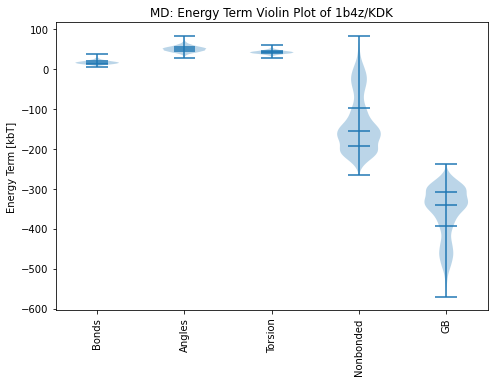

In [75]:
# Plot in Boxplot
fig = plt.figure()
 
# Creating axes instance
ax = fig.add_axes([ 0, 0, 1, 1])
keys = ['O', 'Bonds', 'Angles', 'Torsion', 'Nonbonded', 'GB']
ax.set_xticklabels(keys)

plt.ylabel('Energy Term [kbT]')
#ax.set_yscale('symlog')
 
# Creating plot
bp = ax.violinplot(list(D_MD.values()), showmedians=True, showextrema=True, quantiles=[(0.25, 0.75), (0.25, 0.75), (0.25, 0.75), (0.25, 0.75),(0.25, 0.75)])

plt.xticks(rotation=90)
plt.title('MD: Energy Term Violin Plot of 1b4z/KDK')
plt.savefig(f"figures/ETerms_{nb_fname}_MD.png", bbox_inches="tight")
plt.show()

## NLL

In [8]:
#np.save(f'resdict_NLL_{nb_fname}.npy', resdict_NLL)
# Load
resdict_NLL = np.load(f'resdict_NLL_{nb_fname}.npy',allow_pickle='TRUE').item()
D_NLL = resdict_NLL
D_NLL

{'Bonds': array([26.25834457, 25.37918113, 18.69762027, ..., 16.14267767,
        14.27490684, 10.74778261]),
 'Angles': array([61.52502926, 78.42996227, 61.37457141, ..., 53.02088894,
        71.85701498, 70.22744996]),
 'Torsion': array([41.9239453 , 46.90067477, 47.16777128, ..., 43.63749792,
        45.9724836 , 42.33714584]),
 'Nonbonded': array([-2.81574306e+01, -4.93067745e+00,  9.52775644e+05, ...,
        -1.17163380e+02, -1.47302539e+02,  3.69806572e+01]),
 'GB': array([-463.07905451, -479.85409573, -359.2887659 , ..., -361.18223666,
        -328.67035881, -515.53123066])}

In [9]:
D_NLL["Nonbonded"] = D_NLL["Nonbonded"][D_NLL["Nonbonded"] < np.percentile(D_NLL["Nonbonded"], 90)]

/tmp/ipykernel_16350/2313940528.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(keys)


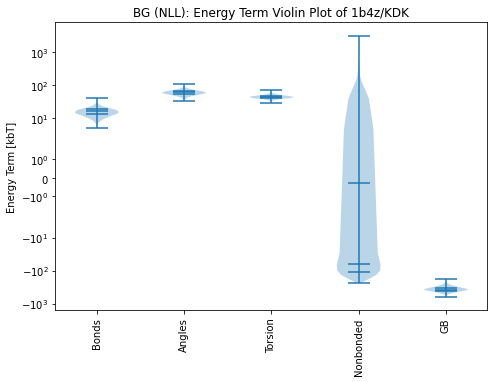

In [89]:
# Plot in Boxplot
fig = plt.figure()
 
# Creating axes instance
ax = fig.add_axes([ 0, 0, 1, 1])
keys = ['O', 'Bonds', 'Angles', 'Torsion', 'Nonbonded', 'GB']
ax.set_xticklabels(keys)

plt.ylabel('Energy Term [kbT]')
ax.set_yscale('symlog')

# Creating plot
bp = ax.violinplot(list(D_NLL.values()), showmedians=True, showextrema=True, quantiles=[(0.25, 0.75), (0.25, 0.75), (0.25, 0.75), (0.25, 0.75),(0.25, 0.75)])

plt.xticks(rotation=90)
plt.title('BG (NLL): Energy Term Violin Plot of 1b4z/KDK')
plt.savefig(f"figures/ETerms_{nb_fname}_NLL.png", bbox_inches="tight")
plt.show()

## Mixed

In [10]:
#np.save(f'resdict_Mixed_{nb_fname}.npy', resdict_Mixed)
# Load
resdict_Mixed = np.load(f'resdict_Mixed_{nb_fname}.npy',allow_pickle='TRUE').item()
D_Mix = resdict_Mixed
D_Mix

{'Bonds': array([21.39594439, 14.31639625, 18.94596895, ..., 13.34814869,
        18.52237958, 13.17412316]),
 'Angles': array([45.7177214 , 71.41569414, 49.78359569, ..., 49.62259511,
        51.55335912, 41.30458808]),
 'Torsion': array([39.87584484, 42.27008292, 41.89883   , ..., 45.78079644,
        46.04128379, 51.90163857]),
 'Nonbonded': array([ -60.51281759,  -19.16826212,  -50.22631361, ...,  -18.68273774,
         753.77707665, -116.13127703]),
 'GB': array([-424.4546926 , -458.1225924 , -422.46837395, ..., -461.32081719,
        -415.41369231, -367.91158845])}

In [11]:
D_Mix["Nonbonded"] = D_Mix["Nonbonded"][D_Mix["Nonbonded"] < np.percentile(D_Mix["Nonbonded"], 90)]

/tmp/ipykernel_16350/2743204561.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(keys)


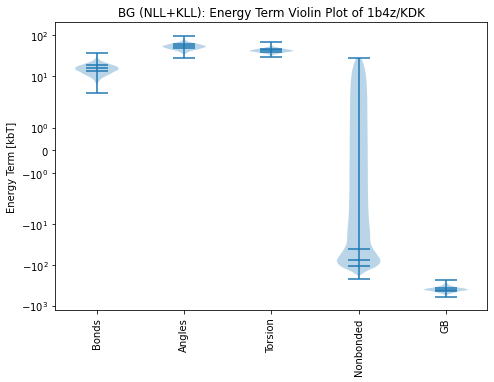

In [189]:
# Plot in Boxplot
fig = plt.figure()
 
# Creating axes instance
ax = fig.add_axes([ 0, 0, 1, 1])
keys = ['O', 'Bonds', 'Angles', 'Torsion', 'Nonbonded', 'GB']
ax.set_xticklabels(keys)

plt.ylabel('Energy Term [kbT]')
ax.set_yscale('symlog')

# Creating plot
bp = ax.violinplot(list(D_Mix.values()), showmedians=True, showextrema=True, quantiles=[(0.25, 0.75), (0.25, 0.75), (0.25, 0.75), (0.25, 0.75),(0.25, 0.75)])

plt.xticks(rotation=90)
plt.title('BG (NLL+KLL): Energy Term Violin Plot of 1b4z/KDK')
plt.savefig(f"figures/ETerms_{nb_fname}_Mixed.png", bbox_inches="tight")
plt.show()

## KLL

In [12]:
#np.save(f'resdict_KLL_{nb_fname}.npy', resdict_KLL)
# Load
resdict_KLL = np.load(f'resdict_KLL_{nb_fname}.npy',allow_pickle='TRUE').item()
D_KLL = resdict_KLL
D_KLL

{'Bonds': array([18.91723267, 22.8678849 , 19.06382254, ..., 19.32114804,
        17.05932642, 17.94477316]),
 'Angles': array([37.81995139, 43.22003899, 49.60996445, ..., 48.86879106,
        55.3947731 , 50.03015428]),
 'Torsion': array([42.60304063, 35.9873658 , 42.95908999, ..., 44.26683473,
        44.46949069, 36.54725362]),
 'Nonbonded': array([-75.14900414, -76.01123291, -96.6292842 , ...,  43.51621951,
        -49.30381331,   6.95426366]),
 'GB': array([-417.82865622, -415.63175273, -400.4569667 , ..., -485.07720417,
        -441.61899097, -496.74711568])}

In [13]:
D_KLL["Nonbonded"] = D_KLL["Nonbonded"][D_KLL["Nonbonded"] < np.percentile(D_KLL["Nonbonded"], 90)]

/tmp/ipykernel_16350/3576405215.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(keys)


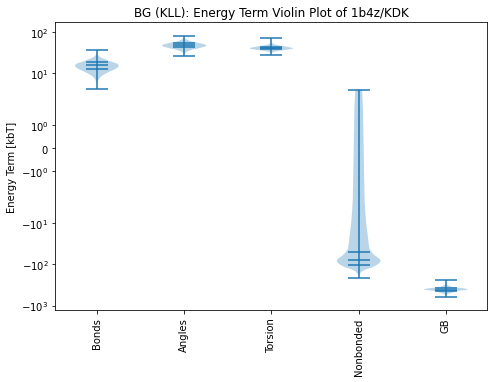

In [182]:
# Plot in Boxplot
fig = plt.figure()
 
# Creating axes instance
ax = fig.add_axes([ 0, 0, 1, 1])
keys = ['O', 'Bonds', 'Angles', 'Torsion', 'Nonbonded', 'GB']
ax.set_xticklabels(keys)

plt.ylabel('Energy Term [kbT]')
ax.set_yscale('symlog')

# Creating plot
bp = ax.violinplot(list(D_KLL.values()), showmedians=True, showextrema=True, quantiles=[(0.25, 0.75), (0.25, 0.75), (0.25, 0.75), (0.25, 0.75),(0.25, 0.75)])

plt.xticks(rotation=90)
plt.title('BG (KLL): Energy Term Violin Plot of 1b4z/KDK')
plt.savefig(f"figures/ETerms_{nb_fname}_KLL.png", bbox_inches="tight")
plt.show()

## KLL (no GB)

In [14]:
#np.save(f'resdict_KLL_no_GB_{nb_fname}.npy', resdict_KLL_no_GB)
# Load
resdict_KLL_no_GB = np.load(f'resdict_KLL_no_GB_{nb_fname}.npy',allow_pickle='TRUE').item()
D_KLL_no_GB = resdict_KLL_no_GB
D_KLL_no_GB

{'Bonds': array([16.76785159, 20.04959989, 19.51781211, ..., 19.54926297,
        18.97382126, 21.6086443 ]),
 'Angles': array([47.6459253 , 45.57072036, 46.72592402, ..., 54.21585315,
        52.27302996, 43.19033589]),
 'Torsion': array([40.04844689, 41.70069987, 54.34709211, ..., 40.76667254,
        34.34526263, 39.27563012]),
 'Nonbonded': array([ -91.61486408, -122.30781414, 1661.96902923, ...,  -12.06752687,
         -63.2740415 , -135.68655803]),
 'GB': array([-382.08102633, -349.7263038 , -446.50605105, ..., -471.77710463,
        -398.75162495, -334.22929674])}

In [15]:
D_KLL_no_GB["Nonbonded"] = D_KLL_no_GB["Nonbonded"][D_KLL_no_GB["Nonbonded"] < np.percentile(D_KLL_no_GB["Nonbonded"], 90)]

/tmp/ipykernel_16350/3038284024.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(keys)


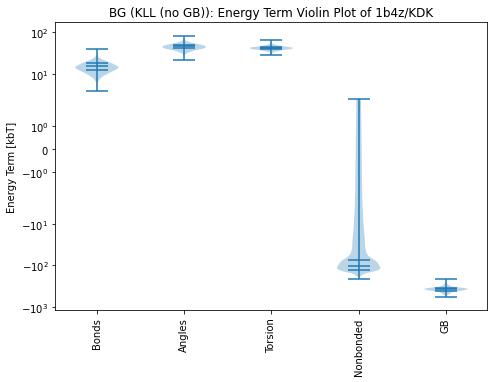

In [195]:
# Plot in Boxplot
fig = plt.figure()
 
# Creating axes instance
ax = fig.add_axes([ 0, 0, 1, 1])
keys = ['O', 'Bonds', 'Angles', 'Torsion', 'Nonbonded', 'GB']
ax.set_xticklabels(keys)

plt.ylabel('Energy Term [kbT]')
ax.set_yscale('symlog')

# Creating plot
bp = ax.violinplot(list(D_KLL_no_GB.values()), showmedians=True, showextrema=True, quantiles=[(0.25, 0.75), (0.25, 0.75), (0.25, 0.75), (0.25, 0.75),(0.25, 0.75)])

plt.xticks(rotation=90)
plt.title('BG (KLL (no GB)): Energy Term Violin Plot of 1b4z/KDK')
plt.savefig(f"figures/ETerms_{nb_fname}_KLL_no_GB.png", bbox_inches="tight")
plt.show()

## Compare NB and GB between MD and BG

First we directly compare the different energy terms directly after training by example and which differ most.

### Violinplot

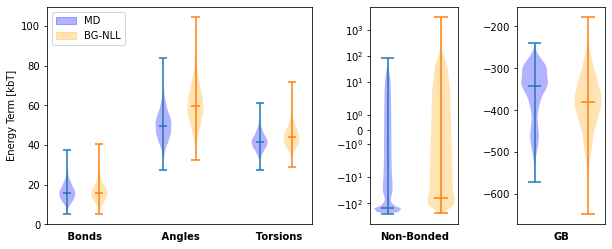

In [215]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(10, 4), gridspec_kw={'width_ratios': [6, 2, 2], 'wspace': 0.4,})

labels = []
def add_label(violin, label):
    color = violin["bodies"][0].get_facecolor().flatten()
    labels.append((mpatches.Patch(color=color), label))

# Plot 1
pos_1 = [1, 4, 7]
pos_2 = [2, 5, 8]

parts_1 = axs[0].violinplot(list(resdict_MD.values())[0:3], pos_1, showmedians=True)

for pc in parts_1['bodies']:
    pc.set_facecolor('blue')
    
add_label(parts_1, "MD")

parts_2 = axs[0].violinplot(list(D_NLL.values())[0:3], pos_2, showmedians=True)

for pc in parts_2['bodies']:
    pc.set_facecolor('orange')

add_label(parts_2, "BG-NLL")

plt.sca(axs[0])
plt.xlabel("   Bonds                 Angles                Torsions", fontweight='bold')
plt.xticks([])


plt.ylabel('Energy Term [kbT]')
plt.legend(*zip(*labels), loc='upper left')

# Plot 2
pos_1 = [1]
pos_2 = [2]

parts_1 = axs[1].violinplot(list(resdict_MD.values())[3:4], pos_1, showmedians=True)

for pc in parts_1['bodies']:
    pc.set_facecolor('blue')
    
add_label(parts_1, "MD")

parts_2 = axs[1].violinplot(list(D_NLL.values())[3:4], pos_2, showmedians=True)

for pc in parts_2['bodies']:
    pc.set_facecolor('orange')

add_label(parts_2, "BG-NLL")

axs[1].set_yscale('symlog')
plt.sca(axs[1])
plt.xlabel("Non-Bonded", fontweight='bold')
plt.xticks([])

# Plot 3
pos_1 = [1]
pos_2 = [2]

parts_1 = axs[2].violinplot(list(resdict_MD.values())[4:5], pos_1, showmedians=True)

for pc in parts_1['bodies']:
    pc.set_facecolor('blue')
    
add_label(parts_1, "MD")

parts_2 = axs[2].violinplot(list(D_NLL.values())[4:5], pos_2, showmedians=True)

for pc in parts_2['bodies']:
    pc.set_facecolor('orange')

add_label(parts_2, "BG-NLL")

#axs[2].set_yscale('symlog')
plt.sca(axs[2])
plt.sca(axs[2])
plt.xlabel("GB", fontweight='bold')
plt.xticks([])


#fig.suptitle("Energy Terms of MD and BG-NLL Samples")

plt.savefig(f"figures/ETerms_{nb_fname}_comp_MD_NLL.png", bbox_inches="tight")
plt.show()

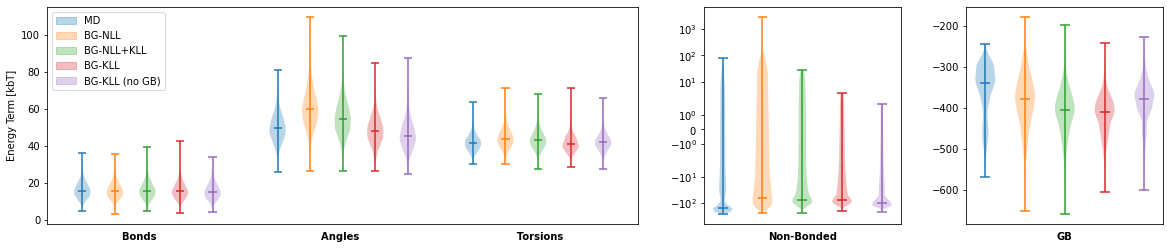

In [17]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 4), gridspec_kw={'width_ratios': [12, 4, 4], 'wspace': 0.2,})

labels = []
def add_label(violin, label):
    color = violin["bodies"][0].get_facecolor().flatten()
    labels.append((mpatches.Patch(color=color), label))

# Plot 1
pos_1 = [1, 7, 13]
pos_2 = [2, 8, 14]
pos_3 = [3, 9, 15]
pos_4 = [4, 10, 16]
pos_5 = [5, 11, 17]

parts_1 = axs[0].violinplot(list(resdict_MD.values())[0:3], pos_1, showmedians=True)

#for pc in parts_1['bodies']:
    #pc.set_facecolor('blue')
    
add_label(parts_1, "MD")

parts_2 = axs[0].violinplot(list(D_NLL.values())[0:3], pos_2, showmedians=True)

#for pc in parts_2['bodies']:
 #   pc.set_facecolor('orange')

add_label(parts_2, "BG-NLL")

parts_3 = axs[0].violinplot(list(D_Mix.values())[0:3], pos_3, showmedians=True)

#for pc in parts_3['bodies']:
 #   pc.set_facecolor('gold')

add_label(parts_3, "BG-NLL+KLL")

parts_4 = axs[0].violinplot(list(D_KLL.values())[0:3], pos_4, showmedians=True)

#for pc in parts_4['bodies']:
 #   pc.set_facecolor('green')

add_label(parts_4, "BG-KLL")

parts_5 = axs[0].violinplot(list(D_KLL_no_GB.values())[0:3], pos_5, showmedians=True)

#for pc in parts_5['bodies']:
 #   pc.set_facecolor('red')

add_label(parts_5, "BG-KLL (no GB)")

plt.sca(axs[0])
plt.xlabel("Bonds                                               Angles                                             Torsions", fontweight='bold')
plt.xticks([])


plt.ylabel('Energy Term [kbT]')
plt.legend(*zip(*labels), loc='upper left')

# Plot 2
pos_1 = [1]
pos_2 = [2]
pos_3 = [3]
pos_4 = [4]
pos_5 = [5]

parts_1 = axs[1].violinplot(list(resdict_MD.values())[3:4], pos_1, showmedians=True)

#for pc in parts_1['bodies']:
 #   pc.set_facecolor('blue')
    
add_label(parts_1, "MD")

parts_2 = axs[1].violinplot(list(D_NLL.values())[3:4], pos_2, showmedians=True)

#for pc in parts_2['bodies']:
  #  pc.set_facecolor('orange')

add_label(parts_2, "BG-NLL")

parts_3 = axs[1].violinplot(list(D_Mix.values())[3:4], pos_3, showmedians=True)

#for pc in parts_3['bodies']:
  #  pc.set_facecolor('gold')

add_label(parts_3, "BG-NLL+KLL")

parts_4 = axs[1].violinplot(list(D_KLL.values())[3:4], pos_4, showmedians=True)

#for pc in parts_4['bodies']:
 #   pc.set_facecolor('green')

add_label(parts_4, "BG-KLL")

parts_5 = axs[1].violinplot(list(D_KLL_no_GB.values())[3:4], pos_5, showmedians=True)

#for pc in parts_5['bodies']:
 #   pc.set_facecolor('red')

add_label(parts_5, "BG-KLL (no GB)")

axs[1].set_yscale('symlog')
plt.sca(axs[1])
plt.xlabel("Non-Bonded", fontweight='bold')
plt.xticks([])

# Plot 3
pos_1 = [1]
pos_2 = [2]
pos_3 = [3]
pos_4 = [4]
pos_5 = [5]

parts_1 = axs[2].violinplot(list(resdict_MD.values())[4:5], pos_1, showmedians=True)

#for pc in parts_1['bodies']:
 #   pc.set_facecolor('blue')
    
add_label(parts_1, "MD")

parts_2 = axs[2].violinplot(list(D_NLL.values())[4:5], pos_2, showmedians=True)

#for pc in parts_2['bodies']:
 #   pc.set_facecolor('orange')

add_label(parts_2, "BG-NLL")

parts_3 = axs[2].violinplot(list(D_Mix.values())[4:5], pos_3, showmedians=True)

#for pc in parts_3['bodies']:
  #  pc.set_facecolor('gold')

add_label(parts_3, "BG-NLL+KLL")

parts_4 = axs[2].violinplot(list(D_KLL.values())[4:5], pos_4, showmedians=True)

#for pc in parts_4['bodies']:
 #   pc.set_facecolor('green')

add_label(parts_4, "BG-KLL")

parts_5 = axs[2].violinplot(list(D_KLL_no_GB.values())[4:5], pos_5, showmedians=True)

#for pc in parts_5['bodies']:
  #  pc.set_facecolor('red')

add_label(parts_5, "BG-KLL (no GB)")

#axs[2].set_yscale('symlog')
plt.sca(axs[2])
plt.xlabel("GB", fontweight='bold')
plt.xticks([])


#fig.suptitle("Energy Terms of MD and BG-NLL Samples")

plt.savefig(f"figures/ETerms_{nb_fname}_comp_MD_NLL_full.png", bbox_inches="tight")
plt.show()

### Barplot

In [ ]:
plt.bar(range(len(resdict_MD)), list(resdict_MD.values()), -0.3, align='edge', label='MD')

plt.bar(range(len(resdict_NLL)), list(resdict_NLL.values()), +0.3, align='edge', color='orange', label='BG-NLL')

plt.xticks(range(len(D)), list(D.keys()))
ax = plt.gca()
#ax.set_ylim([-1000, 4000])
max_y_lim = max(resdict_NLL.values()) + 50
min_y_lim = min(resdict_NLL.values()) - 50
plt.ylim(min_y_lim, max_y_lim)
plt.ylabel('Energy Term [kbT]')
#ax.set_yscale('symlog')
plt.xticks(rotation=90)
plt.legend(loc='lower left')
plt.savefig(f"figures/ETerms_{nb_fname}_comp_MD_NLL.png", bbox_inches="tight")
plt.show()

As the BG seems to be easily able to correctly sample the Energies of the Molecules Bonds, Angles and Torsions - which can be seen in the above comparison - the Nonbonded and GB Energy Terms are compared between the MD snapshots and the samples after NLL and KLL training.

### Violinplot

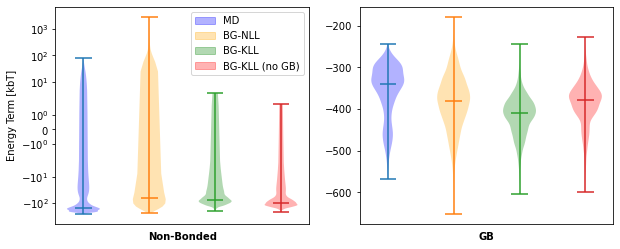

In [37]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), gridspec_kw={'width_ratios': [5, 5], 'wspace': 0.2,})

labels = []
def add_label(violin, label):
    color = violin["bodies"][0].get_facecolor().flatten()
    labels.append((mpatches.Patch(color=color), label))

# Plot 1
pos_1 = [1]
pos_2 = [2]
pos_3 = [3]
pos_4 = [4]

parts_1 = axs[0].violinplot(list(D_MD.values())[3:4], pos_1, showmedians=True)
for pc in parts_1['bodies']:
    pc.set_facecolor('blue')   
add_label(parts_1, "MD")

parts_2 = axs[0].violinplot(list(D_NLL.values())[3:4], pos_2, showmedians=True)
for pc in parts_2['bodies']:
    pc.set_facecolor('orange')
add_label(parts_2, "BG-NLL")

parts_3 = axs[0].violinplot(list(D_KLL.values())[3:4], pos_3, showmedians=True)
for pc in parts_3['bodies']:
    pc.set_facecolor('green')   
add_label(parts_3, "BG-KLL")

parts_4 = axs[0].violinplot(list(D_KLL_no_GB.values())[3:4], pos_4, showmedians=True)
for pc in parts_4['bodies']:
    pc.set_facecolor('red')
add_label(parts_4, "BG-KLL (no GB)")

axs[0].set_yscale('symlog')
plt.sca(axs[0])
plt.xlabel("Non-Bonded", fontweight='bold')
plt.xticks([])

plt.ylabel('Energy Term [kbT]')
plt.legend(*zip(*labels), loc='upper right')

# Plot 2
pos_1 = [1]
pos_2 = [2]
pos_3 = [3]
pos_4 = [4]

parts_1 = axs[1].violinplot(list(D_MD.values())[4:5], pos_1, showmedians=True)
for pc in parts_1['bodies']:
    pc.set_facecolor('blue')   
add_label(parts_1, "MD")

parts_2 = axs[1].violinplot(list(D_NLL.values())[4:5], pos_2, showmedians=True)
for pc in parts_2['bodies']:
    pc.set_facecolor('orange')
add_label(parts_2, "BG-NLL")

parts_3 = axs[1].violinplot(list(D_KLL.values())[4:5], pos_3, showmedians=True)
for pc in parts_3['bodies']:
    pc.set_facecolor('green')   
add_label(parts_3, "BG-KLL")

parts_4 = axs[1].violinplot(list(D_KLL_no_GB.values())[4:5], pos_4, showmedians=True)
for pc in parts_4['bodies']:
    pc.set_facecolor('red')
add_label(parts_4, "BG-KLL (no GB)")

#axs[1].set_yscale('symlog')
plt.sca(axs[1])
plt.xlabel("GB", fontweight='bold')
plt.xticks([])



#fig.suptitle("Non-Bonded Energy Terms of MD and BG-NLL Samples")

plt.savefig(f"figures/ETerms_{nb_fname}_comp_NB_GB_MD_KLL.png", bbox_inches="tight")
plt.show()

### Barplot

In [ ]:
ind = np.arange(2)  # the x locations for the groups
width = 0.15      # the width of the bars


plt.bar(ind - width, list(list(resdict_MD.values())[3:5]), width, align='edge', label='MD')

plt.bar(ind, list(list(resdict_NLL.values())[3:5]), width, align='edge', color='purple', label='BG-NLL')

plt.bar(ind + width, list(list(resdict_KLL.values())[3:5]), width, align='edge', color='orange', label='BG-KLL')

plt.bar(ind + 2*width, list(list(resdict_KLL_no_GB.values())[3:5]), width, align='edge', color='red', label='BG-KLL (no GB)')


plt.xticks(range(len(list(resdict_MD.values())[3:5])), list(resdict_MD.keys())[3:5], ha='center', rotation=0)
ax = plt.gca()
#ax.set_ylim([-1000, 4000])
max_y_lim = max(resdict_KLL.values()) + 50
min_y_lim = min(resdict_KLL.values()) - 50
plt.ylim(min_y_lim, max_y_lim)
plt.ylabel('Energy Term [kbT]')
#ax.set_yscale('symlog')
#plt.xticks(ha='right', rotation=0)
plt.legend(loc='lower left')
plt.savefig(f"figures/ETerms_{nb_fname}_comp_NB_GB_MD_KLL.png", bbox_inches="tight")
plt.show()

It can now clearly be seen that the BG samples do not reach the nonbonded energy of the MD samples. Even though, the nonbonded energy reduces after the training by energy. Only looking at the total energy is not sufficient to approximate if the samples of the BG are good. As we can see here, while the nonbonded energy is not as minimised as in the MD data, the GB energy is even lower compared to the MD data. This can already observed for pure training by example, indicating that the BG generally samples samples with a lower GB energy more easily.

## Visualize Energies

In [ ]:
def plot_tics2(xyz, ax, system=system, lims=((-1.5, 2), (-1.5, 3.5))):
    n_samples = xyz.shape[0]
    xyz = as_numpy(xyz.reshape(n_samples, -1))
    tics = system.to_tics(xyz)
    
    ax.hist2d(
        tics[:,0], tics[:,1], 
        bins=100,
        range=lims, 
        norm=LogNorm(vmax=10, vmin=1e-4),
        density=True
    )
    ax.set_xlabel("TIC1")
    ax.set_ylabel("TIC2")
    ax.set_xlim(*lims[0])
    ax.set_ylim(*lims[1])
    
    

def show_structures(traj, top=system.mdtraj_topology):
    if not isinstance(traj, md.Trajectory):
        n_samples = traj.shape[0]
        traj = md.Trajectory(traj.reshape(n_samples, -1, 3), topology=top)
    traj.superpose(traj)
    widget = nv.show_mdtraj(traj)
    widget.add_representation("licorice")
    return widget
    
def evaluate_generator_unsorted(generator, samples, energies, true_target = False, num_energy = 1000, num_widget = 100, cut = None):
    fig, axes = plt.subplots(1, 2, figsize=(10,5))
    
    if true_target:
        plot_energies(axes[1], samples[:num_energy], generator._target, test_data, cut)
    else:
        plot_energies(axes[1], samples[:num_energy], CutTarget, test_data, cut)
        
    #c_atoms = system.mdtraj_topology.select("backbone and (name C or name N)")#[:3]
    #pcs = system.pca_model.transform(coordinate_transform(torch.Tensor(samples))[2])
    
    dihed = dihedrals(samples.reshape((10000,n_atoms,3)))
    dihed = pca_fit_md.transform(dihed)
    
    #tics = system.tica_model.transform(distances(samples.reshape(samples.shape[0],-1,3)[:,c_atoms,:]), eigs_kept=2) 
    #tics = system.to_tics(samples.reshape(samples.shape[0],-1,3), eigs_kept=2)
    #plot_tics(axes[0], tics)
    
    plot_pcs(axes[0], dihed)
    fig.tight_layout()
    
    plt.savefig(f"figures/EVis_{nb_fname}_KLL_no_GB.png")
    
    global widget
    widget = show_structures(samples[:100])
    
    init_value = np.around(energies[0].item(), decimals = 2)
    output2 = widgets.BoundedFloatText(
        value = init_value,
        description='Energy:',
        disabled=True,
        min = -1e20,
        max = 1e50
    )
    display(output2)
    
    def on_value_change(change):
        value = np.around(energies[change['new']].item(), decimals = 2)
        output2.value = value
    widget._iplayer._trait_values["children"][1].observe(on_value_change, names='value')

    display(widget)    


    
    
def plot_energies(ax, samples, target_energy, test_data, train_type, cut = None):
    sample_energies = target_energy.energy(torch.Tensor(samples)).numpy()

    md_energies = target_energy.energy(test_data[:len(samples)]).cpu().detach().numpy()
    if cut is None:   
        cut = max(np.percentile(sample_energies, 80), 20)
    ax.set_xlabel("Energy   [$k_B T$]")
    # y-axis on the right
    ax2 = plt.twinx(ax)
    ax.get_yaxis().set_visible(False)
    
    ax2.hist(sample_energies, range=(min(md_energies).item(), cut), bins=40, density=False, label="BG")
    ax2.hist(md_energies, range=(min(md_energies).item(), cut), bins=40, density=False, label="MD", alpha = 0.5)
    ax2.set_ylabel(f"Count   [#Samples / {len(samples)}]")
    ax2.legend()

In [ ]:
torsions = coordinate_transform(training_data[3000:].cpu())[2]

pca = IncrementalPCA(n_components=2, batch_size = 100)
for k in range(100):
    pca.fit(torsions[k*100:(k+1)*100])

system.pca_model = pca

CutTarget = LinLogCutEnergy(generator._target)

#evaluate_generator_unsorted(generator, samples, samples_energies,true_target = True, cut = 0)

In [ ]:
#we have to take these with a grain of salt: still the energy is so low, because we compensate our high lennard jones with GB terms.
#if we remove the GB term completely, we get mode collapse
#this is because the reverse KL divergence (KLL) is mode seeking, whereas the forward KL divergence (NLL) is mean seeking (or mode covering)

#it would be better if we had used a combinatin of NLL and KLL to avoid mode collapse, but this doesnt get used the low energies we ask for

### NLL

In [ ]:
num_samples = 10000
samples = np.concatenate([
    as_numpy(generator.sample(100))
    for _ in tqdm(range(100))
])
bg_samples = generator.sample(num_samples)
bg_traj = md.Trajectory(bg_samples.reshape(num_samples,-1,3).cpu().detach().numpy(), system.mdtraj_topology)
#bg_traj.save_hdf5(f"bg_traj_NLL_{nb_fname}.h5")
#bg_traj.save_pdb(f"bg_traj_NLL_{nb_fname}.pdb")

samples_energies = generator._target.energy(torch.Tensor(samples))

sort = torch.argsort(samples_energies,0)
energies_sorted = samples_energies[sort].squeeze()
samples_sorted = samples[sort]

evaluate_generator_unsorted(generator, samples, samples_energies)

In [50]:
traj_NLL=md.load_hdf5(f"bg_traj_NLL_{nb_fname}.h5")

traj_NLL.n_atoms
data = traj_NLL.xyz.reshape(len(traj_NLL.xyz), -1)

wid=show_structures(data)
wid

NGLWidget(max_frame=9999)

### NLL + KLL

In [ ]:
num_samples = 10000
bg_samples = generator.sample(num_samples)
bg_traj = md.Trajectory(bg_samples.reshape(num_samples,-1,3).cpu().detach().numpy(), system.mdtraj_topology)
#bg_traj.save_hdf5(f"bg_traj_Mixed_{nb_fname}.h5")
#bg_traj.save_pdb(f"bg_traj_Mixed_{nb_fname}.pdb")

samples = np.concatenate([
    as_numpy(generator.sample(100))
    for _ in tqdm(range(100))
])

samples_energies = generator._target.energy(torch.Tensor(samples))

sort = torch.argsort(samples_energies,0)
energies_sorted = samples_energies[sort].squeeze()
samples_sorted = samples[sort]

evaluate_generator_unsorted(generator, samples, samples_energies)

In [51]:
traj_Mixed=md.load_hdf5(f"bg_traj_Mixed_{nb_fname}.h5")

traj_Mixed.n_atoms
data = traj_Mixed.xyz.reshape(len(traj_Mixed.xyz), -1)

wid=show_structures(data)
wid

NGLWidget(max_frame=9999)

### KLL

In [ ]:
num_samples = 10000
bg_samples = generator.sample(num_samples)
bg_traj = md.Trajectory(bg_samples.reshape(num_samples,-1,3).cpu().detach().numpy(), system.mdtraj_topology)
#bg_traj.save_hdf5(f"bg_traj_KLL_{nb_fname}.h5")
#bg_traj.save_pdb(f"bg_traj_KLL_{nb_fname}.pdb")

samples = np.concatenate([
    as_numpy(generator.sample(100))
    for _ in tqdm(range(100))
])

samples_energies = generator._target.energy(torch.Tensor(samples))

sort = torch.argsort(samples_energies,0)
energies_sorted = samples_energies[sort].squeeze()
samples_sorted = samples[sort]

evaluate_generator_unsorted(generator, samples, samples_energies)

## Investigate Energies of open and closed samples

In [ ]:
pos = []
        #B, A, T, BB, c1, C2, C3, C4, j = generator.flow(torch.Tensor(valdata[:BATCHSIZE]).to(ctx["device"]), inverse = True)
for _ in tqdm(range(n_batches)):


    zB, zA, znT, ztT = generator.prior.sample(BATCHSIZE)
    #bp()
    samples = generator.flow(zB, zA, znT, ztT)[0].detach().cpu().reshape(BATCHSIZE,-1,3).numpy()
    #p = generator.sample(BATCHSIZE).cpu().detach().reshape(BATCHSIZE,-1,3).numpy()
    pos.append(samples)


positions = np.concatenate(pos)
for p in tqdm(positions):
    Context.setPositions(p)
    for i, (q, n) in enumerate(zip(quants,names)):
        #ipdb.set_trace()
        state = Context.getState(
                        getEnergy=True,
                        getForces=False,
                        getPositions=False,
                        groups = {i})
        #ipdb.set_trace()
        energies[n].append(state.getPotentialEnergy())

In [ ]:
samples_energies[0]

In [ ]:
# First, the generator after KLL training is loaded and energies are calculated with the code block above
# Using the following the GB and NB energy of a certain sample can be accessed

# Sample number X is a very 'open' confirmation (can be seen in nglviewer below)

GB_14 = np.array(energies['GB']._value[14])
NB_14 = np.array(energies['Nonbonded']._value[14])

GB_19 = np.array(energies['GB']._value[19])
NB_19 = np.array(energies['Nonbonded']._value[19])

GB_20 = np.array(energies['GB']._value[20])
NB_20 = np.array(energies['Nonbonded']._value[20])

GB_30 = np.array(energies['GB']._value[30])
NB_30 = np.array(energies['Nonbonded']._value[30])


# Sample number X is a very 'closed' confirmation (can be seen in nglviewer below)
GB_0 = np.array(energies['GB']._value[0])
NB_0 = np.array(energies['Nonbonded']._value[0])

GB_1 = np.array(energies['GB']._value[1])
NB_1 = np.array(energies['Nonbonded']._value[1])

GB_2 = np.array(energies['GB']._value[2])
NB_2 = np.array(energies['Nonbonded']._value[2])

GB_6 = np.array(energies['GB']._value[6])
NB_6 = np.array(energies['Nonbonded']._value[6])

In [ ]:
GB_c = [GB_0, GB_1, GB_2, GB_6]
GB_o = [GB_14, GB_19, GB_20, GB_30]
NB_c = [NB_0, NB_1, NB_2, NB_6]
NB_o = [NB_14, NB_19, NB_20, NB_30]

keys = ["GB - closed", "GB - open", "NB - closed", "NB - open"]

dist_values = [GB_c, GB_o, NB_c, NB_o]


# Plot in Boxplot
fig = plt.figure()
 
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
ax.set_xticklabels(keys)
 
# Creating plot
bp = ax.boxplot(dist_values)

plt.xticks(rotation=90)
plt.ylabel('Energy [kbT]')

plt.savefig(f"figures/open_closed_conf_GB_NB_{nb_fname}.png", bbox_inches="tight")
plt.show()

#Performing a 2-sided t-test on the data
test = scipy.stats.ttest_ind(GB_c, GB_o)
print(test)

In [52]:
traj_KLL=md.load_hdf5(f"bg_traj_KLL_{nb_fname}.h5")

traj_KLL.n_atoms
data = traj_KLL.xyz.reshape(len(traj_KLL.xyz), -1)

wid=show_structures(data)
wid

NGLWidget(max_frame=9999)

### KLL (no GB)

In [ ]:
num_samples = 10000
bg_samples = generator.sample(num_samples)
bg_traj = md.Trajectory(bg_samples.reshape(num_samples,-1,3).cpu().detach().numpy(), system.mdtraj_topology)
#bg_traj.save_hdf5(f"bg_traj_KLL_no_GB_{nb_fname}.h5")
#bg_traj.save_pdb(f"bg_traj_KLL__no_GB{nb_fname}.pdb")

samples = np.concatenate([
    as_numpy(generator.sample(100))
    for _ in tqdm(range(100))
])

samples_energies = generator._target.energy(torch.Tensor(samples))

sort = torch.argsort(samples_energies,0)
energies_sorted = samples_energies[sort].squeeze()
samples_sorted = samples[sort]

evaluate_generator_unsorted(generator, samples, samples_energies)

In [53]:
traj_KLL_no_GB=md.load_hdf5(f"bg_traj_KLL_no_GB_{nb_fname}.h5")

traj_KLL_no_GB.n_atoms
data = traj_KLL_no_GB.xyz.reshape(len(traj_KLL_no_GB.xyz), -1)

wid=show_structures(data)
wid

NGLWidget(max_frame=9999)

In [ ]:
# wir sehen hier einen versteckten Mode collapse. Es sind zwar alle TICA-moden drin, aber die samples sind nicht mehr ganz so divers. 
# das ist vermutlich weil wir im letzten training teil den NLL Loss komplett raus genommen haben, dadurch gibt es keine "Bestrafung" mehr,
# wenn Moden aus den training data im latent space "zusammengequentscht" werden. Diesse werden dann nicht mehr gesampled.

## Highlight Clashes

In [ ]:
target_real = system._energy_model
samples_xyz = samples.reshape(len(samples),samples.shape[-1]//3,3)

context = target_real._bridge.context_wrapper._openmm_context

forcelist = []
for id,sample_xyz in tqdm(enumerate(samples_xyz)):
    vec = []
    for i in range(len(sample_xyz)):
        vec.append(openmm.vec3.Vec3(sample_xyz[i,0],sample_xyz[i,1],sample_xyz[i,2]))
    context.setPositions(vec)

    state = context.getState(getPositions = True, getEnergy = True, getForces = True)
    forces = state.getForces(asNumpy = True)._value
    force_magn = np.linalg.norm(forces, axis=1)
    forcelist.append(force_magn)
forces = np.stack(forcelist,axis = 0)        
        #force_magn.argmax()

max_indices = forces.argsort(axis = -1)[:,-2:]

top = system._mdtraj_topology
traj = md.Trajectory(np.array(samples.reshape(samples.shape[0],-1,3)), topology=top)#[5:]
traj.superpose(traj)
#widget = nv.show_mdtraj(traj)
#widget.add_representation("licorice")
#widget

view = nv.show_mdtraj(traj, default_representation=False)
view.add_licorice()
view.add_cartoon(colorScheme = "residueindex")
view.add_ball_and_stick(selection = max_indices[0], color = "pink", aspectRatio = 3.)
view.center()

import time

def on_frame_change(change):
    frame = change['new']
    clashes = max_indices[frame]    
    view._remove_representation(repr_index = 2)
    view.add_ball_and_stick(selection = clashes, color = "pink", aspectRatio = 3.)


view.observe(on_frame_change, names=['frame'])

view

# Further Steps

## Minimize Samples Energy

In [ ]:
#target_real._openmm_energy_bridge._n_simulation_steps = 0
samples_xyz = samples.reshape(len(samples),samples.shape[-1]//3,3)
#prmtop = openmm.app.amberprmtopfile.AmberPrmtopFile(os.path.join(filepath,'stripped_combined.prmtop'))
simulation = openmm.app.simulation.Simulation(system._topology, system.system, openmm.LangevinIntegrator(300, 1, 0.002))
threshold = Quantity(value=-1655.9926, unit=kilojoule/mole)

#context = target_real._openmm_energy_bridge.context_wrapper._openmm_context

samples_xyz_subset = samples_xyz[:10]

In [ ]:
# do keyboard interrupt once you have minimized some samples, no need to minimize them all.
reporter = NetCDFReporter('relaxation.nc', 1)
reporter_bad = NetCDFReporter('relaxation_bad.nc', 1)

samples_minimized =  []
samples_energies = []
for id,sample_xyz in tqdm(enumerate(samples_xyz_subset)):
    vec = []
    for i in range(len(sample_xyz)):
        vec.append(openmm.vec3.Vec3(sample_xyz[i,0],sample_xyz[i,1],sample_xyz[i,2]))
    #context = target_real._openmm_energy_bridge.context_wrapper._openmm_context
    context.setPositions(positions = vec)
    state = context.getState(getPositions = True, getEnergy = True)
    #simulation.reporters.append(NetCDFReporter('relaxation.nc', 1))
    #state = simulation.context.getState(getPositions = True, getEnergy = True)
    #e0 = state.getPotentialEnergy()
    energies = []
    #positions = []
    e = state.getPotentialEnergy()
    energies.append(e)
    reporter.report(simulation,state)
    while e > threshold:
        e2 = copy.copy(e)
        LocalEnergyMinimizer.minimize(context,maxIterations = 2)
        state = context.getState(getPositions = True, getEnergy = True)
        #pos = state.getPositions()
        
        e = state.getPotentialEnergy()
        #ipdb.set_trace()
        if e2 == e or len(energies) > 20:
            if e2 == e:
                reporter_bad.report(simulation,state)
            break
        energies.append(e)
        reporter.report(simulation,state)

        #simulation.minimizeEnergy(maxIterations = 2)
        
        #ipdb.set_trace()
        #positions.append(pos)
        
    #state = context.getState(getPositions = True, getEnergy = True)
    #pos = state.getPositions()
    #e = state.getPotentialEnergy()
    reporter.report(simulation,state)
    energies.append(e)
    #positions.append(pos)


    #simulation.step(1i00)
    #state = simulation.context.getState(getPositions = True, getEnergy = True)
    minimized = torch.Tensor(np.array(state.getPositions(asNumpy = True).reshape((1,system.topology._numAtoms*3))))

    samples_minimized.append(minimized)
    #ipdb.set_trace()
    samples_energies.append(e)
samples_minimized = torch.cat(samples_minimized)
samples_energies = torch.cat(samples_energies)

#inp.median([energy._value for energy in samples_energies])

### Visualize Relaxation

In [ ]:
#traj = pt.load('relaxation.nc', top=os.path.join(filepath,'stripped_combined.prmtop'))
##traj = traj.superpose(traj)
##data_relax = traj.xyz.reshape(len(traj.xyz), -1)
#wid = nglview.show_pytraj(traj)
#wid.add_representation("licorice")
#wid

traj = md.load_netcdf('relaxation.nc', top=system._mdtraj_topology)
traj = traj.superpose(traj)
data_relax = traj.xyz.reshape(len(traj.xyz), -1)[31:]
wid = show_structures(data_relax)
wid

## Sampling Efficiency

In [ ]:
#this is a measure for the quality of the BG samples.
#A perfect generator would have sampling efficiency of 1.
from torch.utils.data import DataLoader 

weightdata = test_data[list(np.random.choice(len(test_data),1000))]
weightloader = DataLoader(weightdata, batch_size=100, shuffle=True, drop_last = True)
log_w = []
for batch in weightloader:
    log_w.append(generator.log_weights(batch.to(**ctx)))
log_w = torch.cat(log_w)
bg.sampling_efficiency(log_w)


# Marginals of the torsions/angles/bonds

In [ ]:
def plot_ics(name, data, data2=None, data3=None, chosen=None):
    data = assert_numpy(data)
    if data2 is not None:
        data2 = assert_numpy(data2)
    if data3 is not None:
        data3 = assert_numpy(data3)
    if chosen is None:
        chosen = np.random.choice(range(len(data[0,:])))
    plt.figure(figsize=(14, 4))
    plt.subplot(1,2,1)
    plt.title(name+' %d of %d'%(chosen+1, len(data[0,:])))
    plt.plot(data[:,chosen], 'o')
    if data2 is not None:
        plt.plot(data2[:,chosen], 'o')
    if data3 is not None:
        plt.plot(data3[:,chosen], 'o')
    plt.subplot(1,2,2)
    plt.hist(data[:,chosen], bins=50, density=True, histtype='step', label='target')
    if data2 is not None:
        plt.hist(data2[:,chosen], bins=50, density=True, histtype='step', label='generated')
    if data3 is not None:
        plt.hist(data3[:,chosen], bins=50, density=True, histtype='step', label='prior')
    plt.legend()
    plt.show()

## NLL

In [ ]:
n_samples = 10000

samples = np.concatenate([
    as_numpy(generator.sample(100))
    for _ in tqdm(range(100))
])

with torch.no_grad():
    ics_t = coordinate_transform.forward(training_data[:n_samples].to(**ctx))
    ics_m = coordinate_transform.forward(torch.Tensor(samples).to(**ctx))
    # ics_m = generator.prior.sample(n_samples)
    l = 2
    title = ['bonds', 'angles', 'torsions', 'fixed', 'euler', 'dlogp']
    for i in range(ics_t[l].shape[1]):
        plot_ics(title[l], ics_t[l], data2=ics_m[l], chosen=i)
    del ics_t, ics_m

## NLL + KLL

In [ ]:
n_samples = 10000

samples = np.concatenate([
    as_numpy(generator.sample(100))
    for _ in tqdm(range(100))
])


with torch.no_grad():
    ics_t = coordinate_transform.forward(training_data[:n_samples].to(**ctx))
    ics_m = coordinate_transform.forward(torch.Tensor(samples).to(**ctx))
    # ics_m = generator.prior.sample(n_samples)
    l = 2
    title = ['bonds', 'angles', 'torsions', 'fixed', '???', 'dlogp']
    for i in range(ics_t[l].shape[1]):
        plot_ics(title[l], ics_t[l], data2=ics_m[l], chosen=i)
    del ics_t, ics_m

## KLL

In [ ]:
n_samples = 10000

samples = np.concatenate([
    as_numpy(generator.sample(100))
    for _ in tqdm(range(100))
])

with torch.no_grad():
    ics_t = coordinate_transform.forward(training_data[:n_samples].to(**ctx))
    ics_m = coordinate_transform.forward(torch.Tensor(samples).to(**ctx))
    # ics_m = generator.prior.sample(n_samples)
    l = 2
    title = ['bonds', 'angles', 'torsions', 'fixed', '???', 'dlogp']
    for i in range(ics_t[l].shape[1]):
        plot_ics(title[l], ics_t[l], data2=ics_m[l], chosen=i)
    del ics_t, ics_m

## KLL (no GB)

In [ ]:
from tqdm import tqdm
from bgflow.utils import as_numpy

n_samples = 10000

samples = np.concatenate([
    as_numpy(generator.sample(100))
    for _ in tqdm(range(100))
])


with torch.no_grad():
    ics_t = coordinate_transform.forward(training_data[:n_samples].to(**ctx))
    ics_m = coordinate_transform.forward(torch.Tensor(samples).to(**ctx))
    # ics_m = generator.prior.sample(n_samples)
    l = 2
    title = ['bonds', 'angles', 'torsions', 'fixed', '???', 'dlogp']
    for i in range(ics_t[l].shape[1]):
        plot_ics(title[l], ics_t[l], data2=ics_m[l], chosen=i)
    del ics_t, ics_m